In [1]:
import pandas as pd
import psycopg2
import pandas.io.sql as psql
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict, cross_validate
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from collections import OrderedDict
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
import matplotlib.cm as cm
import time
import scipy.sparse
import seaborn as sns
import lightgbm as lgb

dosTPath = "../../../../../dosT/ffunes/"
unTPath = "../../../../../unT/ffunes/"

%matplotlib inline

sns.set_theme()

# Obtener menciones de PostgreSQL

In [2]:
try:
    conn = psycopg2.connect(user = "ffunes",
                            password = "location8",
                            host = "127.0.0.1",
                            port = "5432",
                            database = "elecciones_twitter")
except:
    print("No se pudo conectar a la base de datos")

In [ ]:
total_mentions = pd.read_sql_query('SELECT COUNT(*) FROM mentions',con=conn)
total_mentions

In [ ]:
pd.read_sql_query('SELECT * FROM mentions LIMIT 2',con=conn)

In [ ]:
mentions = pd.read_sql_query(
    'SELECT *\
    FROM mentions AS m\
    INNER JOIN (SELECT id, user_id as owner\
    FROM tweets WHERE user_id IN (SELECT id FROM users_location_bbox)) AS t\
    ON m.id_tweet=t.id'
    ,con=conn
)

Vamos a reducir un poco la cantidad de información a cargar, agarremos aquellas menciones que solo fueron usadas en tweets geolocalizados (Aquellos que usamos para entrenar)

17 millones de menciones fueron usadas en, como mucho, 17 millones de tweets, analicemos mejor esto

In [7]:
pd.read_sql_query(
    'SELECT COUNT(*)\
    FROM mentions\
    WHERE id_tweet IN\
        (SELECT id FROM tweets WHERE place_bounding_box IS NOT NULL)'
    ,con=conn
)

count
0  17501743

In [8]:
mentions = pd.read_sql_query(
    'SELECT *\
    FROM mentions\
    WHERE id_tweet IN\
        (SELECT id FROM tweets WHERE place_bounding_box IS NOT NULL)'
    ,con=conn
)

Tenemos 9 millones de tweets con menciones 

In [43]:
mentions["id_tweet"].nunique()

9252559

In [13]:
mentions.rename(columns={'user_id':'user_mentioned'}, inplace=True)

In [14]:
usecols = [
    "id",
    "user_id"
]

In [12]:
tweets_with_mentions = pd.read_pickle(dosTPath + "tweets_with_geolocalization_geonames.pkl")

In [15]:
tweets_with_mentions = tweets_with_mentions.loc[:, usecols]

In [16]:
tweets_with_mentions = pd.merge(
    left=tweets_with_mentions,
    right=mentions,
    how='inner',
    left_on=["id"],
    right_on=["id_tweet"],
    validate="1:m" 
)

In [20]:
del tweets_with_mentions['id_tweet']

In [21]:
tweets_with_mentions.shape

(12093144, 3)

In [22]:
tweets_with_mentions.head(2)

id     user_id      user_mentioned
0  1100241025979871233  2592160172          3338127287
1  1095450052556931072  2592160172  976226064648364033

6.4 millones de tweets tienen menciones

In [46]:
tweets_with_mentions["id"].nunique()

6424832

In [44]:
tweets_with_mentions.to_csv(dosTPath + "mentions_with_tweets_geonames.csv")

Analicemos a los usuarios mencionados por otros usuarios contados una unica vez. Tenemos 1.2 millones de usuarios mencionados en total

In [6]:
tweets_with_mentions["user_mentioned"].nunique()

1192600

# Análisis de menciones

In [4]:
tweets_with_mentions = pd.read_csv(dosTPath + "mentions_with_tweets_geonames.csv")
del tweets_with_mentions["Unnamed: 0"]

In [5]:
tweets_with_mentions.head(2)

id     user_id      user_mentioned
0  1100241025979871233  2592160172          3338127287
1  1095450052556931072  2592160172  976226064648364033

In [4]:
mention_count = tweets_with_mentions.loc[:,['user_id', 'user_mentioned']].\
    drop_duplicates().groupby('user_mentioned').count()

Tener en cuenta el valor de user_mentioned?

In [5]:
mention_count.head()

user_id
user_mentioned         
12                  211
13                    9
18                    1
20                    2
21                    2

In [6]:
mention_count.shape

(1192600, 1)

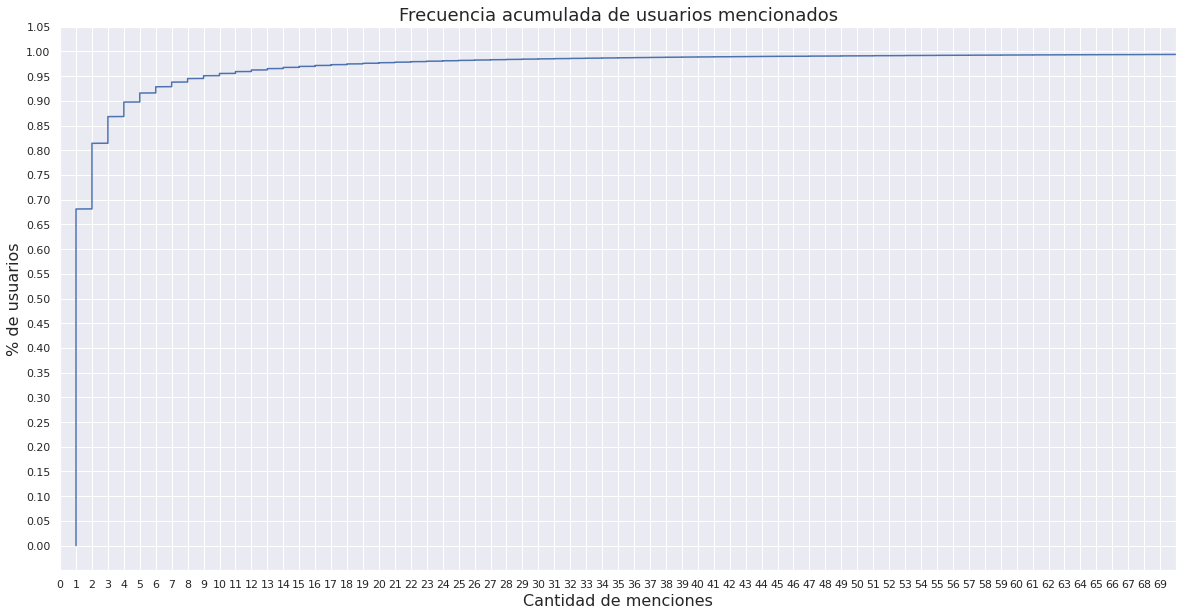

In [7]:
ecdf = ECDF(mention_count["user_id"])

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Cantidad de menciones", fontsize=16)
plt.ylabel("% de usuarios", fontsize=16)
plt.title("Frecuencia acumulada de usuarios mencionados", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.05))
plt.xticks(np.arange(0,70,1))
plt.xlim(0, 70)
#plt.hlines(accuracy_score(y_test[:, 0], y_predicted_city), -200, 1000, colors='r', linestyles='dashed')
#plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

In [7]:
count = mention_count.reset_index()
lim_mentioned_users = count.loc[
    ((count["user_id"] >= 1) & (count["user_id"] <= 10000)) |
    ((count["user_id"] >= 100) & (count["user_id"] <= 1000)),
    ["user_mentioned"]
]

Con cuantos usuarios mencionados nos quedamos?

In [8]:
lim_mentioned_users.shape[0]

1192599

In [9]:
lim_mentioned_users.shape[0] / mention_count.shape[0]

0.9999991614958913

In [10]:
tweets_with_mentions_limit = pd.merge(
    left=tweets_with_mentions,
    right=lim_mentioned_users,
    how='inner',
    left_on=["user_mentioned"],
    right_on=["user_mentioned"],
    validate="m:1" 
)
tweets_with_mentions_limit.shape

(12017358, 3)

Nos quedamos con 1.968 millones de tweets

In [11]:
tweets_with_mentions_limit["id"].nunique()

6402696

In [12]:
tweets_with_mentions_limit.head(2)

id     user_id      user_mentioned
0  1100241025979871233  2592160172          3338127287
1  1095450052556931072  2592160172  976226064648364033

In [13]:
usecols = [
    "id",
    "place_name",
    "place_country",
    "latitude",
    "longitude"
]

In [14]:
users = pd.read_pickle(dosTPath + "total_users_parsed.pkl")

In [15]:
users = users.loc[:, usecols]

In [16]:
users.head()

id           place_name place_country   latitude  longitude
0  773970163502870528  guadalajara de buga      colombia   3.900890 -76.297829
1            77573705                quito       ecuador  -0.229850 -78.524948
2  782687718576840704               tolosa        españa  43.134838  -2.078010
3  781920345536225280            san pedro     argentina -33.679180 -59.666328
4            78502559            guayaquil       ecuador  -2.196160 -79.886208

In [17]:
users.shape

(176029, 5)

In [18]:
users_with_mentions = pd.merge(
    left=users,
    right=tweets_with_mentions_limit.loc[:, ["user_mentioned", "user_id"]],
    how='inner',
    left_on=["id"],
    right_on=["user_id"],
    validate="1:m" 
)
del users_with_mentions["id"]

In [19]:
users_with_mentions.head()

place_name place_country   latitude  longitude      user_mentioned  \
0      quito       ecuador  -0.229850 -78.524948           300390462   
1      quito       ecuador  -0.229850 -78.524948            14369839   
2      quito       ecuador  -0.229850 -78.524948           343818604   
3     tolosa        españa  43.134838  -2.078010            10228272   
4     tolosa        españa  43.134838  -2.078010  862042934023159809   

              user_id  
0            77573705  
1            77573705  
2            77573705  
3  782687718576840704  
4  782687718576840704

In [29]:
users_with_mentions = users_with_mentions.groupby(
        ["user_id", "place_name", "place_country", "latitude", "longitude"]
    )['user_mentioned'].apply(list).reset_index(name='users_mentioned')

In [30]:
users_with_mentions.head(2)

user_id place_name   place_country   latitude  longitude  \
0     1081     boston  estados unidos  34.025379 -87.758362   
1     2677      lenox  estados unidos  42.356480 -73.284828   

                   users_mentioned  
0  [238475531, 18139461, 26270913]  
1                     [3321458604]

In [31]:
users_with_mentions.shape

(129334, 6)

In [ ]:
users_with_mentions.to_pickle(dosTPath + "users_with_mentions.pkl")

# Función para calcular distancias entre datos predecidos y reales

In [2]:
geonames = pd.read_pickle(dosTPath + "geonames_parsed.pkl")

from math import radians, sin, cos, atan2, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371 # km

    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) \
        * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c

    return d

def determine_distance(row):
    predicted_lat = row['predicted_lat']
    predicted_lon = row['predicted_lon']
    real_lat = row['real_lat']
    real_long = row['real_lon']
    
    return haversine_distance(predicted_lat, predicted_lon, real_lat, real_long)

def get_difference_distance(predicted_place, real_place):
    df_prediction = pd.DataFrame({
        'predicted_place': predicted_place,
        'real_place': real_place
    }, dtype=float)
        
    df_prediction[['predicted_cities','predicted_countries']] = df_prediction.predicted_place.str.split(',', expand=True) 
    df_prediction[['real_cities','real_countries']] = df_prediction.real_place.str.split(',', expand=True) 
    
    del df_prediction['predicted_place']
    del df_prediction['real_place']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['predicted_cities', 'predicted_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    df_prediction.rename(columns={'latitude': 'predicted_lat', 'longitude': 'predicted_lon'}, inplace=True)
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['real_cities', 'real_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction.rename(columns={'latitude': 'real_lat', 'longitude': 'real_lon'}, inplace=True)
    
    #print(df_prediction.head(5))
    
    print("Total NaN: ", df_prediction.shape[0]-df_prediction.dropna(subset=['real_lat', 'real_lon', 'predicted_lat', 'predicted_lon']).shape[0])

    return df_prediction.apply(determine_distance, axis=1)

def accuracy_161km(real_place, pred_place):
    dif_distance = get_difference_distance(pred_place, real_place)
    
    total_positives = 0
    
    for val in dif_distance:
        if val <= 161:
            total_positives += 1
    
    return total_positives / len(dif_distance)

# Predicciones

In [6]:
users_with_mentions = pd.read_pickle(dosTPath + "users_with_mentions.pkl")

In [7]:
users_with_mentions["users_mentioned"] = users_with_mentions["users_mentioned"].apply(lambda l: list(map(str, l)))
users_with_mentions["user_id"] = users_with_mentions["user_id"].apply(lambda l: str(l))

In [8]:
users_with_mentions.loc[:, ['users_mentioned']] = users_with_mentions["users_mentioned"].apply(lambda l: list(map(str, l)))

In [9]:
users_with_mentions["unified_place"] = users_with_mentions["place_name"] + ',' + users_with_mentions["place_country"]

In [10]:
min_determined_place = users_with_mentions.loc[:, ["user_id", "unified_place"]].groupby("unified_place").count().sort_values('user_id', ascending=False).reset_index()

In [11]:
min_determined_place = min_determined_place.loc[min_determined_place["user_id"] >= 875, :]

In [12]:
min_determined_place.shape

(23, 2)

In [13]:
users_train_selected = pd.merge(
    left=users_with_mentions,
    right=min_determined_place.loc[:, ['unified_place']],
    how='inner',
    left_on='unified_place',
    right_on='unified_place',
    validate='m:1'
)
users_train_selected.shape

(60097, 7)

Armado de matriz de adyascencia

In [11]:
users_ids = users_train_selected["user_id"].apply(lambda l: str(l)).unique()

set_users = set(users_ids)

for x in users_train_selected["users_mentioned"].values:
    set_users |= set(x)

mentioned_users = list(set_users.difference(set(users_ids)))

total_users = list(users_ids) + mentioned_users

In [12]:
#Verify order

value = True

for i in range(0, len(users_train_selected["user_id"])):
    if total_users[i] != users_train_selected["user_id"][i]:
        value = False

print(value)

True


In [13]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=False,
    vocabulary=total_users
)

vector_of_mentions = vectorizer.fit_transform(users_train_selected["users_mentioned"].apply(lambda x: ' '.join(x))).astype('int')
vector_of_mentions

<60097x607335 sparse matrix of type '<class 'numpy.int64'>'
	with 2279889 stored elements in Compressed Sparse Row format>

In [14]:
users_train_selected.head()

user_id                       place_name place_country   latitude  \
0   624143  ciudad autónoma de buenos aires     argentina -34.613152   
1   819188  ciudad autónoma de buenos aires     argentina -34.613152   
2   822016  ciudad autónoma de buenos aires     argentina -34.613152   
3  1190421  ciudad autónoma de buenos aires     argentina -34.613152   
4  2211011  ciudad autónoma de buenos aires     argentina -34.613152   

   longitude                                    users_mentioned  \
0 -58.377232  [149991703, 25992212, 1305983948, 17232551, 17...   
1 -58.377232  [39176902, 39176902, 4119914644, 169686021, 51...   
2 -58.377232  [124293597, 78299365, 78299365, 78299365, 7829...   
3 -58.377232  [846037885, 846037885, 239643295, 146155608, 4...   
4 -58.377232  [2726973024, 158497464, 158497464, 335462063, ...   

                               unified_place  
0  ciudad autónoma de buenos aires,argentina  
1  ciudad autónoma de buenos aires,argentina  
2  ciudad autónoma de buenos aires,argentina  
3  ciudad autónoma de buenos aires,argentina  
4  ciudad autónoma de buenos aires,argentina

In [30]:
# Save vector of mentions and users
scipy.sparse.save_npz('../../results/matrix/mentions/matrix_mentions_weighted.npz', vector_of_mentions)

total_users_df = pd.DataFrame({"user_id": total_users})
total_users_df.to_pickle("../../results/matrix/mentions/users_mentions.pkl")

total_users_train = users_train_selected.loc[:, ["user_id", "unified_place"]]
total_users_train.to_pickle("../../results/matrix/mentions/users_location.pkl")

Exportamos el grafo de menciones para operar con embeddings

Primero grafo de menciones con pesos en las aristas equivalentes a la cantidad de menciones de un usuario hacia otro

In [15]:
cx = vector_of_mentions.tocoo()
edges = []
checker = list(range(users_train_selected.shape[0]))

for i,j,v in zip(cx.row, cx.col, cx.data):
    #format_str = users_ids[i] + " " + users_ids[j] + " " + str(v)
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)

In [17]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../../results/matrix/mentions/edges_mentions_weighted.csv", header=False, index=False)

Grafo de menciones sin pesos en las aristas

In [18]:
cx = vector_of_mentions.tocoo()
edges = []

for i,j,v in zip(cx.row, cx.col, cx.data):
    format_str = str(i) + " " + str(j)
    edges.append(format_str)

In [19]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../../results/matrix/mentions/edges_mentions_unweighted.csv", header=False, index=False)

Armamos ahora la matriz de co-menciones (Menciones en común entre usuarios)

In [20]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=False,
    vocabulary=total_users
)

vector_of_mentions = vectorizer.fit_transform(users_train_selected["users_mentioned"].apply(lambda x: ' '.join(x))).astype('bool').astype('int')
vector_of_mentions

<60097x607335 sparse matrix of type '<class 'numpy.int64'>'
	with 2279889 stored elements in Compressed Sparse Row format>

In [21]:
vector_of_co_mentions = vector_of_mentions.dot(vector_of_mentions.T)
vector_of_co_mentions.setdiag(0, k=0)

In [22]:
vector_of_co_mentions

<60097x60097 sparse matrix of type '<class 'numpy.longlong'>'
	with 189047195 stored elements in Compressed Sparse Row format>

Matriz de co-menciones completa con pesos

In [23]:
cx = vector_of_co_mentions.tocoo()
edges = []

for i,j,v in zip(cx.row, cx.col, cx.data):
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)

In [24]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../../results/matrix/mentions/edges_comentions_weighted.csv", header=False, index=False)

In [35]:
cx = vector_of_co_mentions.tocoo()
edges = []

temp_values = -1
temp_vecinity = -1

passed = True
last_one = -1

for i,j,v in zip(cx.row, cx.col, cx.data):
    if last_one != i:        
        if not passed:
            format_str = str(last_one) + " " + str(temp_vecinity) + " " + str(temp_values)
            edges.append(format_str)
            
        last_one = i
        passed = False    
        temp_values = -1
        temp_vecinity = -1
    
    if v > 2:
        if v > temp_values:
            temp_values = v
            temp_vecinity = j
        continue
        
    passed = True
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)

In [36]:
len(edges)

148567919

In [37]:
total_edges = 189047195
len(edges)/total_edges

0.785877404845917

In [38]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../../edges_comentions.csv", header=False, index=False)

Datos originales

In [24]:
users_complete_location = users_train_selected.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_selected['unified_place'].unique())

In [25]:
X_train, X_test, y_train, y_test = train_test_split(vector_of_mentions, users_complete_location[:,0], test_size=0.30)

In [26]:
decisiontree = DecisionTreeClassifier()
decisiontree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [ ]:
param_grid= {'max_depth': [8, 80, 200, 500, 2220, 5000, 10000, None], 'min_samples_leaf': [1],
             'class_weight': ['balanced']}
grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

In [ ]:
y_predicted = grid_drop.predict(X_test)

In [ ]:
accuracy_score(y_test, y_predicted)

In [ ]:
balanced_accuracy_score(y_test, y_predicted)

In [ ]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

In [ ]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)

Infomap

In [17]:
!cd ../infomap/infomap-1.1.3 && \
./Infomap --clu -d --silent --weight-threshold 0 ../../edges_mentions.csv ../../

In [18]:
exclude = [i for i, line in enumerate(open('../../edges_mentions.clu')) if line.startswith('#')]
communities_infomap = pd.read_csv("../../edges_mentions.clu", names=["user_id", "k", "flow"], skiprows = exclude, sep=" ")
del communities_infomap["flow"]

In [19]:
#communities_infomap = communities_infomap.loc[communities_infomap["user_id"] < users_train_selected.shape[0], :].sort_values("user_id", ascending=True)

In [20]:
communities_infomap.head()

user_id  k
0    34846  1
1   558118  1
2   267195  1
3    34460  1
4    39024  1

In [21]:
def get_original_user_id(row):
    return total_users[row["user_id"]]

communities_infomap["real_user_id"] = communities_infomap.apply(get_original_user_id, axis=1)

In [22]:
users_train_final = pd.merge(
    left=communities_infomap,
    right=users_train_selected,
    how='inner',
    left_on="real_user_id",
    right_on="user_id",
    validate="1:1"
)

In [23]:
users_train_final = users_train_final.sample(frac=1, random_state=4503493)
users_complete_location = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_final['unified_place'].unique())

In [24]:
users_train_final = users_train_final.loc[:, ["k"]]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(users_train_final, users_complete_location[:,0], test_size=0.30)

In [26]:
decisiontree = DecisionTreeClassifier()
decisiontree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [27]:
param_grid= {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1],
             'class_weight': ['balanced']}
grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

{'class_weight': 'balanced', 'min_samples_leaf': 1, 'max_depth': 80} 0.30658110476219697


In [28]:
y_predicted = grid_drop.predict(X_test)

In [29]:
accuracy_score(y_test, y_predicted)

0.31321950948223126

In [30]:
balanced_accuracy_score(y_test, y_predicted)

0.40303972477145183

In [31]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

Total NaN:  0


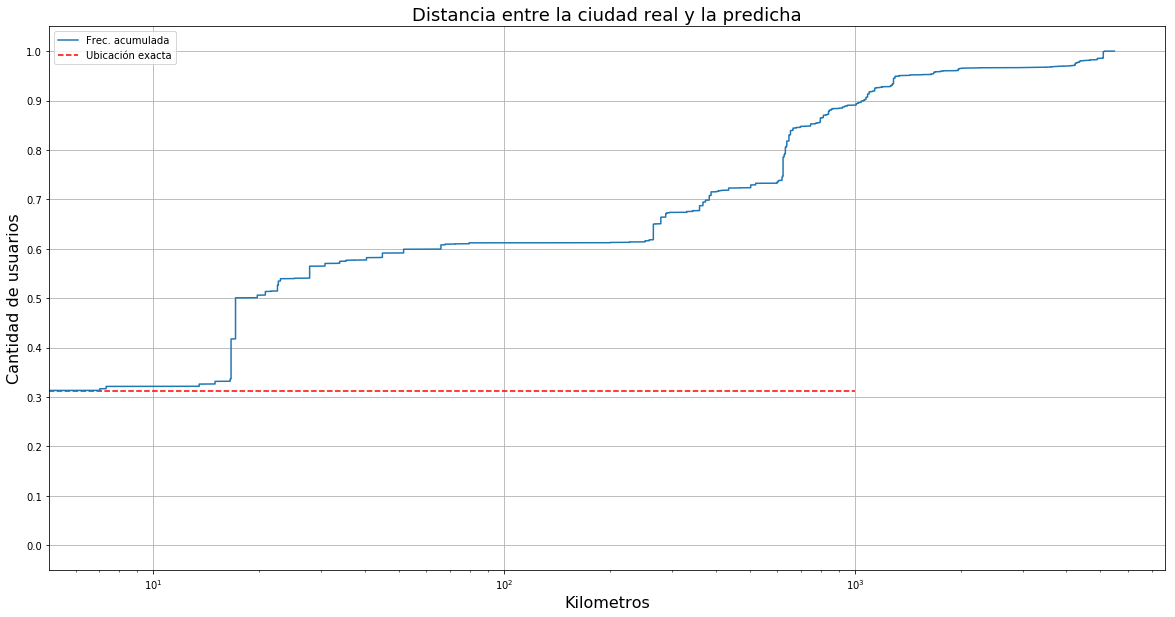

In [32]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

In [54]:
distances_predicted[distances_predicted <= 100].shape[0]/distances_predicted.shape[0]

0.6120349257549635

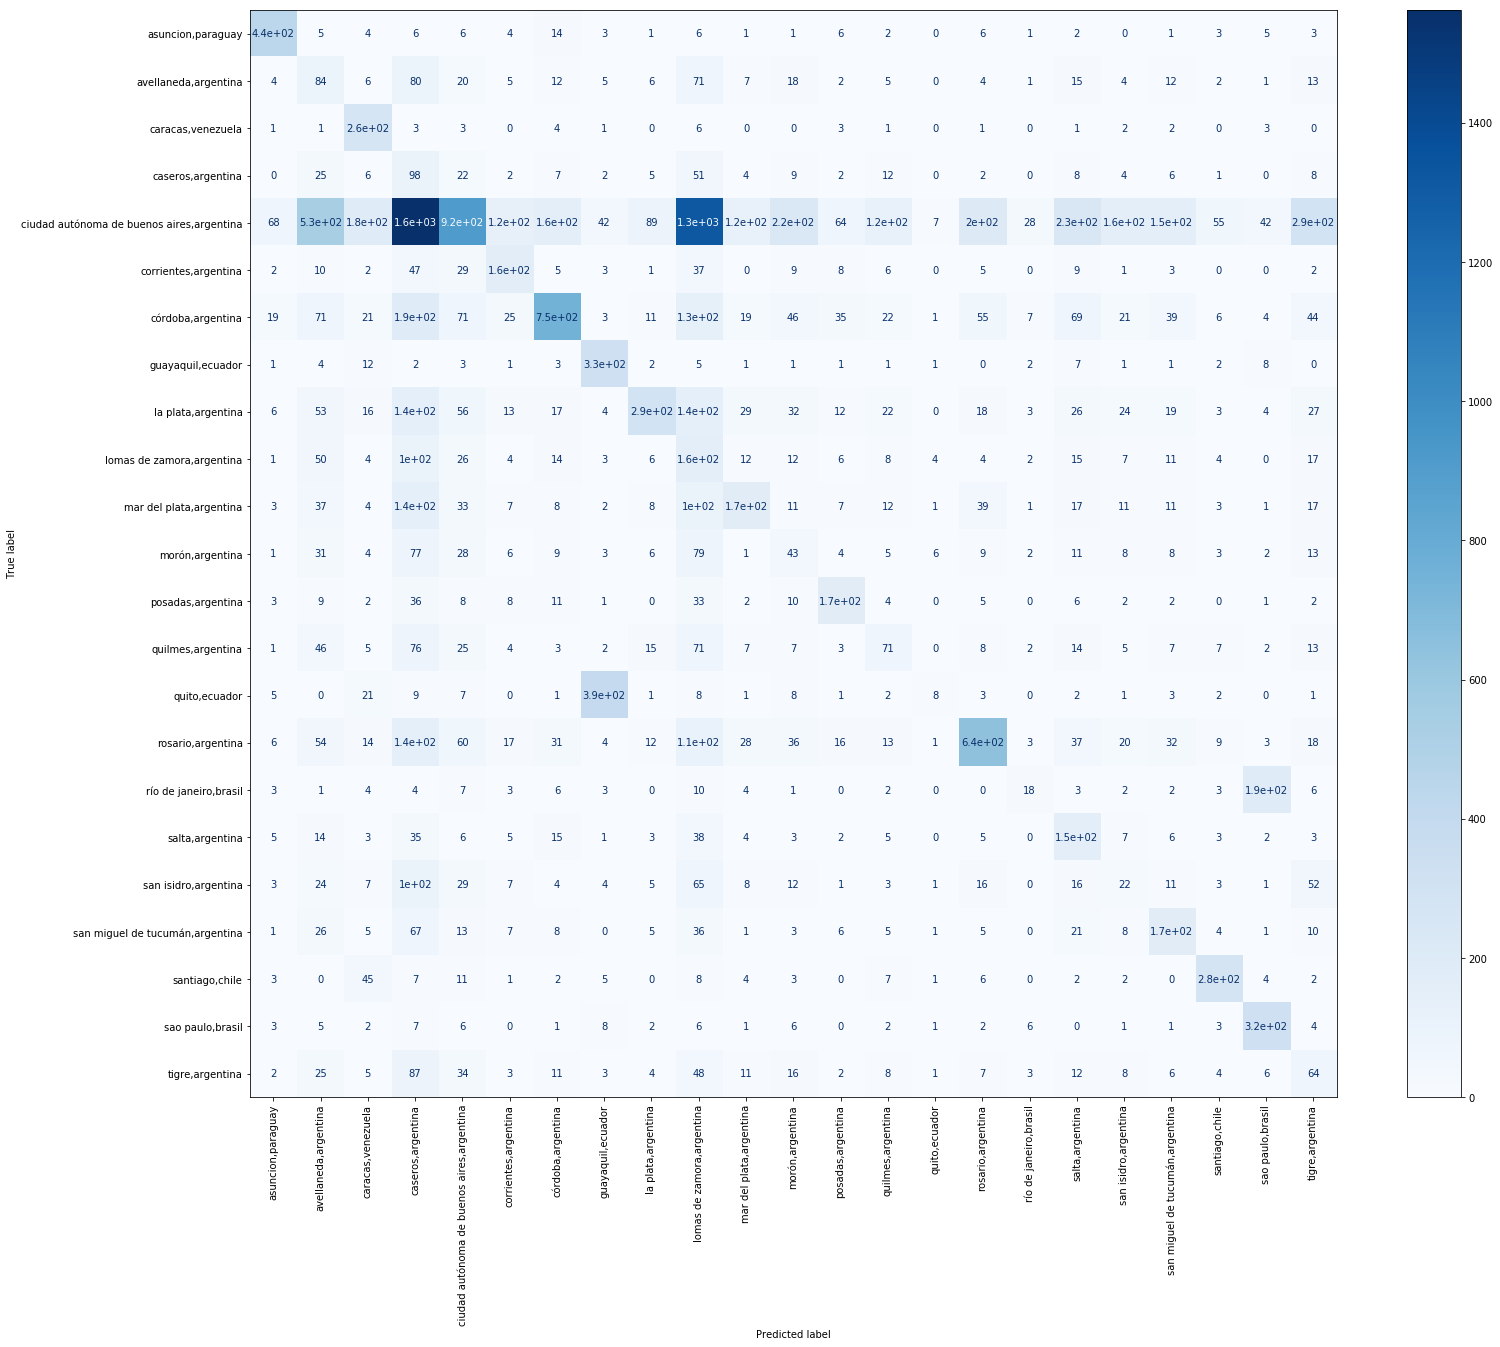

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)

Infomap comentions

In [16]:
!cd ../infomap/infomap-1.1.3 && \
./Infomap --clu -d --silent --weight-threshold 0 ../../edges_comentions.csv ../../

In [17]:
exclude = [i for i, line in enumerate(open('../../edges_comentions.clu')) if line.startswith('#')]
communities_infomap = pd.read_csv("../../edges_comentions.clu", names=["user_id", "k", "flow"], skiprows = exclude, sep=" ")
del communities_infomap["flow"]

In [18]:
communities_infomap.shape

(55514, 2)

In [19]:
def get_original_user_id(row):
    return total_users[row["user_id"]]

communities_infomap["real_user_id"] = communities_infomap.apply(get_original_user_id, axis=1)

In [20]:
users_train_final = pd.merge(
    left=communities_infomap,
    right=users_train_selected,
    how='inner',
    left_on="real_user_id",
    right_on="user_id",
    validate="1:1"
)

In [21]:
users_train_final = users_train_final.sample(frac=1, random_state=4503493)
users_complete_location = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_final['unified_place'].unique())

In [22]:
users_train_final = users_train_final.loc[:, ["k"]]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(users_train_final, users_complete_location[:,0], test_size=0.30)

In [24]:
decisiontree = DecisionTreeClassifier()
decisiontree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [25]:
param_grid= {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1],
             'class_weight': ['balanced']}
grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

{'min_samples_leaf': 1, 'class_weight': 'balanced', 'max_depth': 80} 0.0929518328069979


In [26]:
y_predicted = grid_drop.predict(X_test)

In [27]:
accuracy_score(y_test, y_predicted)

0.10513359351546082

In [28]:
balanced_accuracy_score(y_test, y_predicted)

0.11893634192476003

In [29]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

Total NaN:  0


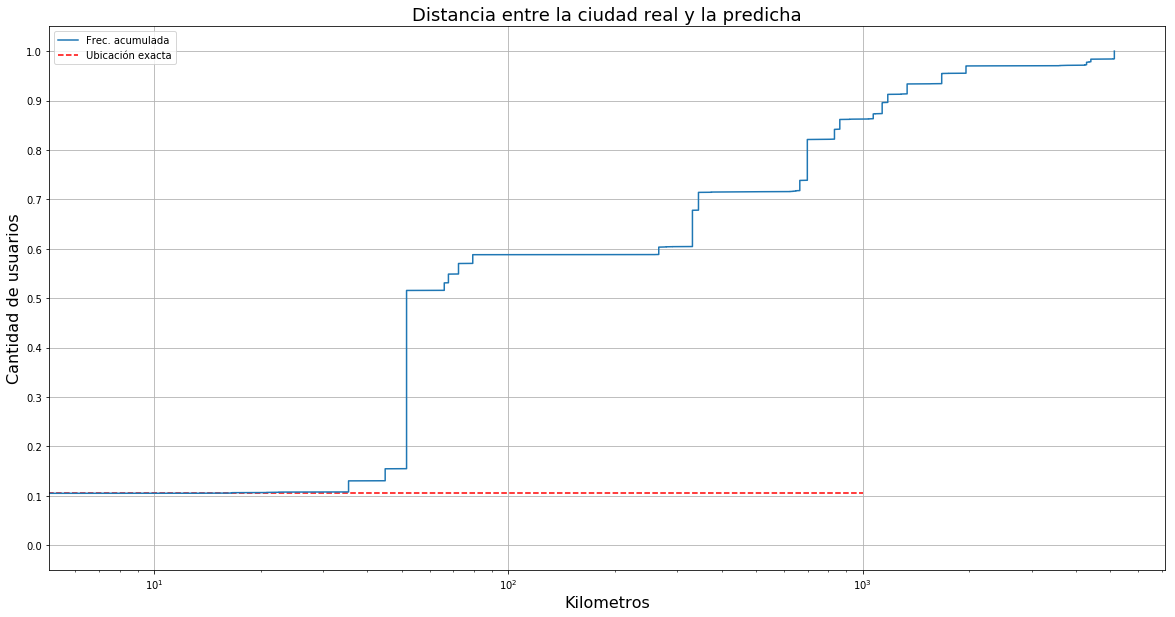

In [30]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)

Node2vec

In [122]:
!cd ../snap/examples/node2vec && \
./node2vec -i:../../../edges_mentions_weighted.csv -o:../../../edges_mentions_weighted_node2vec_16dim.emb -d:16 -p:0.25 -q:0.25 -l:100 -r:10 -w


An algorithmic framework for representational learning on graphs. [Apr 21 2020]
Input graph path (-i:)=../../../edges_mentions_weighted.csv
Output graph path (-o:)=../../../edges_mentions_weighted_node2vec_16dim.emb
Number of dimensions. Default is 128 (-d:)=16
Length of walk per source. Default is 80 (-l:)=100
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=0.25
Inout hyperparameter. Default is 1 (-q:)=0.25
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=YES
Output random walks instead of embeddings. (-ow)=NO


In [111]:
columns_node2vec = ["user_id"]

for i in range(0, 16):
    columns_node2vec.append("dim_{}".format(i))

In [112]:
vector_of_mentions_node2vec = pd.read_csv("../edges_mentions_weighted_node2vec_16dim.emb", names=columns_node2vec, skiprows=1, sep=" ")
#vector_of_mentions_node2vec.drop(range(vector_of_mentions.shape[0], vector_of_mentions.shape[1]), inplace=True)
#vector_of_mentions_node2vec.drop(0, axis=1, inplace=True)
vector_of_mentions_node2vec.shape

(607335, 17)

In [113]:
def get_original_user_id(row):
    return total_users[int(row["user_id"])]

vector_of_mentions_node2vec["real_user_id"] = vector_of_mentions_node2vec.apply(get_original_user_id, axis=1)

In [114]:
vector_of_mentions_node2vec.head()

user_id     dim_0     dim_1     dim_2     dim_3     dim_4     dim_5  \
0   359198 -0.075304 -0.109388  0.089746  0.092006  0.074748  0.084289   
1     4608 -0.125041 -0.174335  0.036212  0.150052  0.118683  0.173397   
2    87021 -0.131449 -0.075500 -0.111242  0.123365 -0.096047  0.163087   
3     3967 -0.275061  0.007053 -0.085884  0.255852  0.032669  0.338139   
4     3697 -0.383660 -0.196422 -0.123053  0.408146  0.067663  0.322509   

      dim_6     dim_7     dim_8     dim_9   dim_10   dim_11   dim_12   dim_13  \
0 -1.244260  0.616738  0.705172 -0.435517 -1.39253 -1.46618  4.43405 -1.66069   
1 -1.270070  0.638292  0.768129 -0.436288 -1.45451 -1.55596  4.77746 -1.70121   
2 -0.853689  0.601520  0.638263 -0.286466 -1.16829 -1.48196  4.28235 -1.59370   
3 -0.869892  0.520139  0.502216 -0.237113 -1.18845 -1.38228  4.09356 -1.45590   
4 -0.995957  0.435952  0.265815 -0.309082 -1.41511 -1.26526  3.89146 -1.24114   

     dim_14   dim_15         real_user_id  
0 -0.343917  2.31547            342181575  
1 -0.377408  2.57972            145457665  
2 -0.310709  2.42063  1152557792982687744  
3 -0.294567  2.32630            137568918  
4 -0.579263  2.37328            133381258

In [115]:
users_train_final = pd.merge(
    left=vector_of_mentions_node2vec,
    right=users_train_selected,
    how='inner',
    left_on="real_user_id",
    right_on="user_id",
    validate="1:1"
)

In [116]:
users_train_final = users_train_final.sample(frac=1, random_state=4503493)
users_complete_location = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_final['unified_place'].unique())

In [117]:
columns_node2vec.remove("user_id")
users_train_final = users_train_final.loc[:, columns_node2vec]

T-SNE

In [95]:
colors = []
for place in users_complete_location[:,0]:
    colors.append(class_names.index(place))

ValueError: 'c' argument has 23 elements, which is not acceptable for use with 'x' with size 60097, 'y' with size 60097.

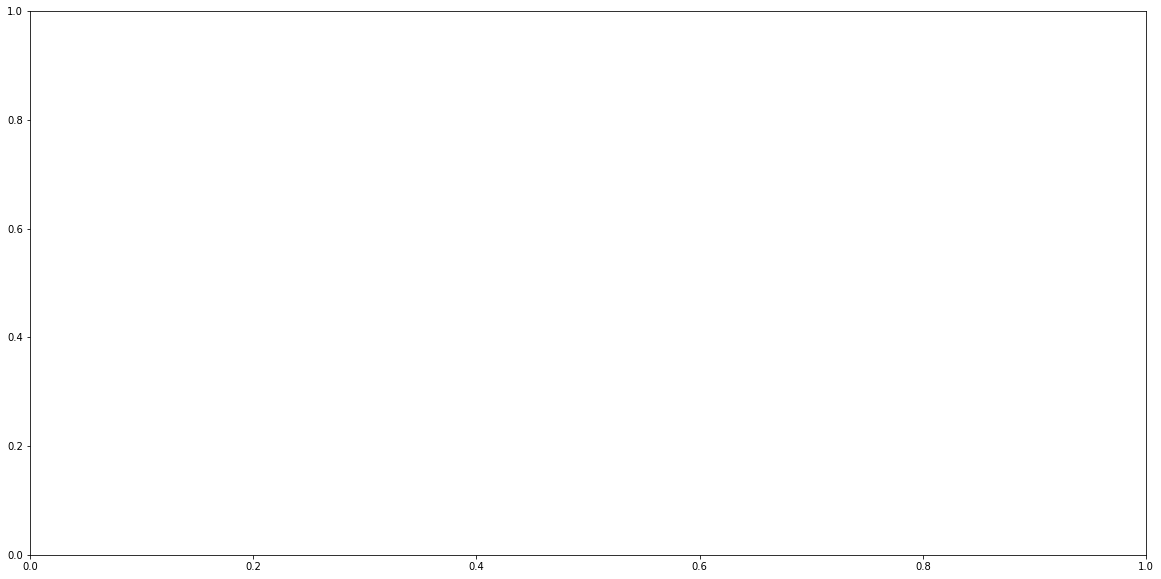

In [118]:
tsne = TSNE(n_components=2, n_jobs=5, perplexity=30, learning_rate=200.0)
X_train_tsne = tsne.fit_transform(users_train_final)

plt.figure(figsize=(20,10)) 

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=colors)
plt.show()

In [120]:
colors[0].reshape(1, 4)

array([[0.5, 0. , 1. , 1. ]])

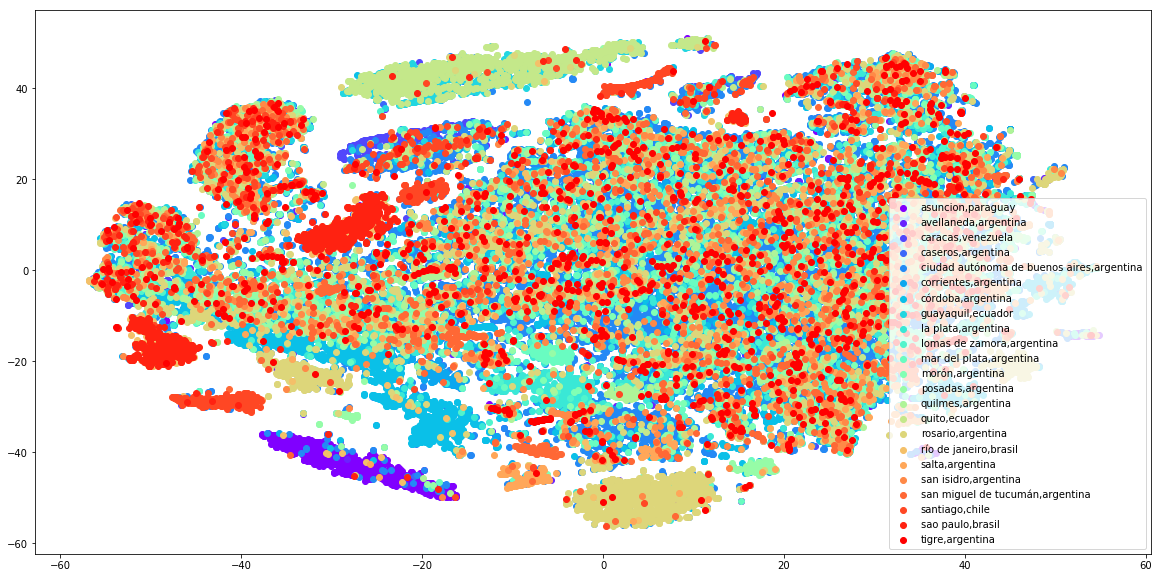

In [121]:
plt.figure(figsize=(20,10)) 
i = 0
#colors = []
colors = cm.rainbow(np.linspace(0, 1, len(class_names)))

for _class in np.array(class_names):
    a = np.where(users_complete_location[:,0] == _class)

    #for _p in range(0, len(a[0])):
    #    colors.append(i)
    
    plt.scatter(X_train_tsne[a[0], 0], X_train_tsne[a[0], 1], c=colors[i].reshape(1, 4), label=_class)
    i = i + 1
    #colors = []
  
plt.legend()    
plt.show()

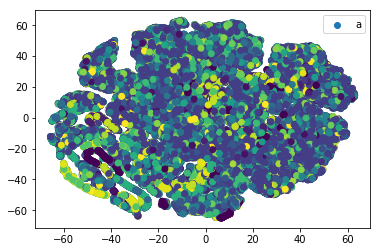

In [51]:
#plt.figure(figsize=(20,10)) 

#fig, ax = plt.subplots()

#scatter = ax.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=colors)#, label=colors)

#legend1 = ax.legend(*scatter.legend_elements(),
#                    loc="lower left", title="Classes")

#plt.legend()

scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=colors)
plt.legend([labels=class_names])

plt.show()

SVD

In [132]:
svd = TruncatedSVD(n_components=2)

In [133]:
users_train_final_svd = svd.fit_transform(users_train_final)

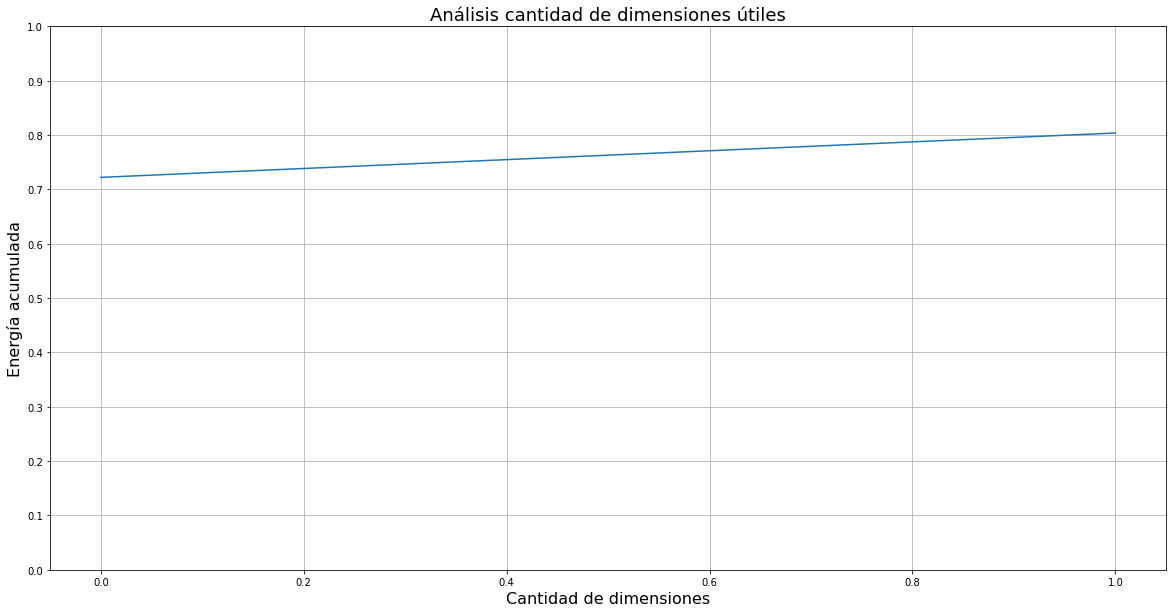

In [134]:
plt.figure(figsize=(20,10)) 

#plt.semilogy(svd.explained_variance_ratio_.cumsum(), '--o')
plt.grid(b=True, which='major')
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel("Cantidad de dimensiones", fontsize=16)
plt.ylabel("Energía acumulada", fontsize=16)
plt.title("Análisis cantidad de dimensiones útiles", fontsize=18)
plt.yticks(np.arange(0,1.1,0.1))
plt.show()

In [135]:
svd.explained_variance_ratio_.cumsum()[-1]

0.8035129727235245

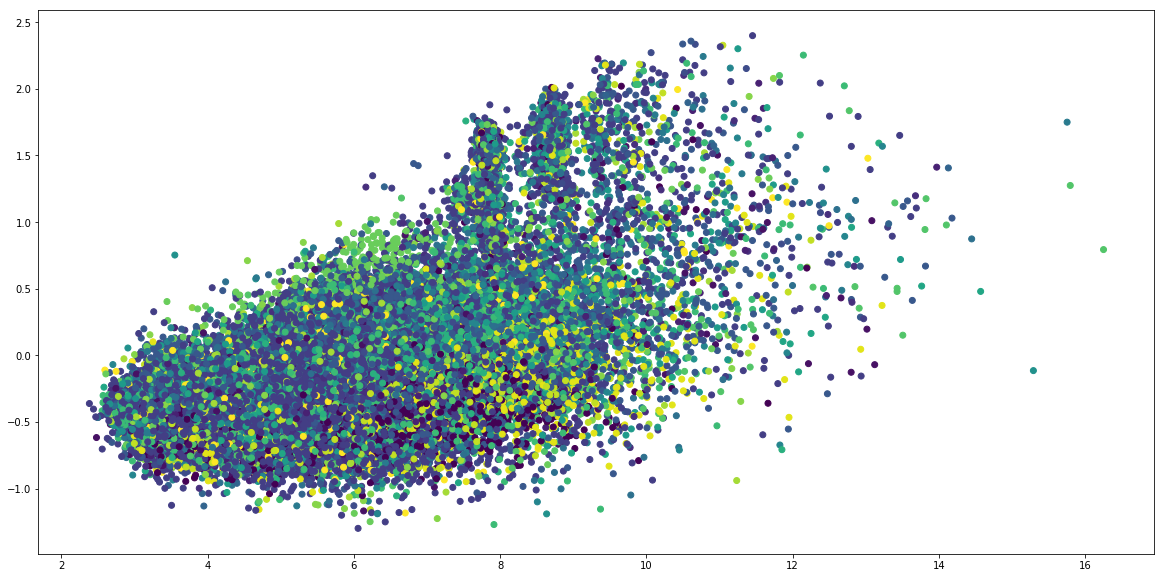

In [136]:
plt.figure(figsize=(20,10)) 
plt.scatter(users_train_final_svd[:, 0], users_train_final_svd[:, 1], c=colors)
#plt.yticks(np.arange(-2, 6, step=0.2))
#plt.xticks(np.arange(-2, 6, step=0.2))
plt.show()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(users_train_final, users_complete_location[:,0], test_size=0.30)

OSLOM

In [ ]:
start = time.time()

!cd ../oslom/OSLOM2 && \
./oslom_dir -f ../../results/matrix/mentions/edges_mentions_weighted.csv -w -r 10 -seed 430430 -cp 0.5

end = time.time()
print(end - start)

setting -f
setting -w
setting -r
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/matrix/mentions/edges_mentions_weighted.csv
Weighted: yes
First Level Runs:			10
Higher Level Runs:			50
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 2277346 factorials...
done
rm: cannot remove '../../results/matrix/mentions/edges_mentions_weighted.csv_oslo_files/*': No such file or directory
output files will be written in directory: ../../results/matrix/mentions/edges_mentions_weighted.csv_oslo_files
network:: 607172 nodes and 2.27735e+06 stubs;	 average degree = 3.75074
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 45398
iteration: 20 number of modules: 27158
collection done 


checked 0 modules 0 were found significant.  Modules to check: 27944. Percentage nodes done: 0
checked 100 modules 86 

checked 6900 modules 5916 were found significant.  Modules to check: 21044. Percentage nodes done: 0.684615
checked 7000 modules 5986 were found significant.  Modules to check: 20944. Percentage nodes done: 0.687108
checked 7100 modules 6053 were found significant.  Modules to check: 20844. Percentage nodes done: 0.690557
checked 7200 modules 6130 were found significant.  Modules to check: 20744. Percentage nodes done: 0.693143
checked 7300 modules 6205 were found significant.  Modules to check: 20644. Percentage nodes done: 0.695524
checked 7400 modules 6285 were found significant.  Modules to check: 20544. Percentage nodes done: 0.697865
checked 7500 modules 6364 were found significant.  Modules to check: 20444. Percentage nodes done: 0.700393
checked 7600 modules 6442 were found significant.  Modules to check: 20344. Percentage nodes done: 0.702605
checked 7700 modules 6502 were found significant.  Modules to check: 20244. Percentage nodes done: 0.705675
checked 7800 modules 6578 we

checked 14500 modules 11005 were found significant.  Modules to check: 13444. Percentage nodes done: 0.836173
checked 14600 modules 11047 were found significant.  Modules to check: 13344. Percentage nodes done: 0.837418
checked 14700 modules 11100 were found significant.  Modules to check: 13244. Percentage nodes done: 0.839164
checked 14800 modules 11157 were found significant.  Modules to check: 13144. Percentage nodes done: 0.840795
checked 14900 modules 11212 were found significant.  Modules to check: 13044. Percentage nodes done: 0.842172
checked 15000 modules 11258 were found significant.  Modules to check: 12944. Percentage nodes done: 0.843456
checked 15100 modules 11310 were found significant.  Modules to check: 12844. Percentage nodes done: 0.844886
checked 15200 modules 11364 were found significant.  Modules to check: 12744. Percentage nodes done: 0.846113
checked 15300 modules 11415 were found significant.  Modules to check: 12644. Percentage nodes done: 0.847478
checked 15

checked 22000 modules 14520 were found significant.  Modules to check: 5944. Percentage nodes done: 0.943548
checked 22100 modules 14550 were found significant.  Modules to check: 5844. Percentage nodes done: 0.944265
checked 22200 modules 14589 were found significant.  Modules to check: 5744. Percentage nodes done: 0.945269
checked 22300 modules 14627 were found significant.  Modules to check: 5644. Percentage nodes done: 0.946106
checked 22400 modules 14679 were found significant.  Modules to check: 5544. Percentage nodes done: 0.947348
checked 22500 modules 14713 were found significant.  Modules to check: 5444. Percentage nodes done: 0.948384
checked 22600 modules 14748 were found significant.  Modules to check: 5344. Percentage nodes done: 0.949336
checked 22700 modules 14784 were found significant.  Modules to check: 5244. Percentage nodes done: 0.950373
checked 22800 modules 14838 were found significant.  Modules to check: 5144. Percentage nodes done: 0.95144
checked 22900 module

checked 3300 unions. Fused: 0
checked 3400 unions. Fused: 0
checked 3500 unions. Fused: 0
checked 3600 unions. Fused: 0
checked 3700 unions. Fused: 0
checked 3800 unions. Fused: 0
checked 3900 unions. Fused: 0
checked 4000 unions. Fused: 0
checked 4700 unions. Fused: 0
checked 4800 unions. Fused: 0
checked 4900 unions. Fused: 0
checked 5000 unions. Fused: 0
checked 5100 unions. Fused: 0
checked 5200 unions. Fused: 0
checked 5300 unions. Fused: 0
checked 5400 unions. Fused: 0
checked 5500 unions. Fused: 0
checked 5600 unions. Fused: 0
checked 5900 unions. Fused: 0
checked 6100 unions. Fused: 0
checked 6200 unions. Fused: 0
checked 7000 unions. Fused: 0
checked 7100 unions. Fused: 0
checked 7200 unions. Fused: 0
checked 7300 unions. Fused: 0
checked 7400 unions. Fused: 0
checked 7500 unions. Fused: 0
checked 7700 unions. Fused: 0
checked 7800 unions. Fused: 0
checked 7900 unions. Fused: 1
checked 8000 unions. Fused: 1
checked 8300 unions. Fused: 1
checked 8400 unions. Fused: 1
checked 85

checked 5600 unions. Fused: 0
checked 5700 unions. Fused: 0
checked 5800 unions. Fused: 0
checked 5900 unions. Fused: 0
checked 6200 unions. Fused: 0
checked 6400 unions. Fused: 0
checked 6600 unions. Fused: 0
checked 7000 unions. Fused: 0
checked 7100 unions. Fused: 0
checked 7200 unions. Fused: 0
checked 7300 unions. Fused: 0
checked 7400 unions. Fused: 0
checked 7600 unions. Fused: 0
checked 7700 unions. Fused: 0
checked 7800 unions. Fused: 0
checked 7900 unions. Fused: 0
checked 8000 unions. Fused: 0
checked 8100 unions. Fused: 0
checked 8400 unions. Fused: 0
checked 8700 unions. Fused: 0
checked 8800 unions. Fused: 0
checked 9000 unions. Fused: 0
checked 9300 unions. Fused: 0
checked 9400 unions. Fused: 0
checked 9500 unions. Fused: 0
checked 9600 unions. Fused: 0
checked 9700 unions. Fused: 0
checked 10200 unions. Fused: 0
checked 10300 unions. Fused: 0
checked 10400 unions. Fused: 0
checked 10500 unions. Fused: 0
checked 10600 unions. Fused: 0
checked 10700 unions. Fused: 0
chec

checked 1100 modules 1009 were found significant.  Modules to check: 26928. Percentage nodes done: 0.429649
checked 1200 modules 1093 were found significant.  Modules to check: 26828. Percentage nodes done: 0.436687
checked 1300 modules 1187 were found significant.  Modules to check: 26728. Percentage nodes done: 0.448237
checked 1400 modules 1279 were found significant.  Modules to check: 26628. Percentage nodes done: 0.454347
checked 1500 modules 1358 were found significant.  Modules to check: 26528. Percentage nodes done: 0.461074
checked 1600 modules 1452 were found significant.  Modules to check: 26428. Percentage nodes done: 0.467769
checked 1700 modules 1537 were found significant.  Modules to check: 26328. Percentage nodes done: 0.475084
checked 1800 modules 1621 were found significant.  Modules to check: 26228. Percentage nodes done: 0.480608
checked 1900 modules 1706 were found significant.  Modules to check: 26128. Percentage nodes done: 0.485917
checked 2000 modules 1795 we

checked 8700 modules 7271 were found significant.  Modules to check: 19328. Percentage nodes done: 0.727188
checked 8800 modules 7352 were found significant.  Modules to check: 19228. Percentage nodes done: 0.729604
checked 8900 modules 7425 were found significant.  Modules to check: 19128. Percentage nodes done: 0.731801
checked 9000 modules 7496 were found significant.  Modules to check: 19028. Percentage nodes done: 0.73396
checked 9100 modules 7576 were found significant.  Modules to check: 18928. Percentage nodes done: 0.736295
checked 9200 modules 7657 were found significant.  Modules to check: 18828. Percentage nodes done: 0.738697
checked 9300 modules 7725 were found significant.  Modules to check: 18728. Percentage nodes done: 0.741317
checked 9400 modules 7788 were found significant.  Modules to check: 18628. Percentage nodes done: 0.743014
checked 9500 modules 7867 were found significant.  Modules to check: 18528. Percentage nodes done: 0.745601
checked 9600 modules 7948 wer

checked 16300 modules 11932 were found significant.  Modules to check: 11728. Percentage nodes done: 0.862553
checked 16400 modules 11989 were found significant.  Modules to check: 11628. Percentage nodes done: 0.863787
checked 16500 modules 12029 were found significant.  Modules to check: 11528. Percentage nodes done: 0.865328
checked 16600 modules 12079 were found significant.  Modules to check: 11428. Percentage nodes done: 0.866438
checked 16700 modules 12138 were found significant.  Modules to check: 11328. Percentage nodes done: 0.867766
checked 16800 modules 12183 were found significant.  Modules to check: 11228. Percentage nodes done: 0.868899
checked 16900 modules 12228 were found significant.  Modules to check: 11128. Percentage nodes done: 0.870605
checked 17000 modules 12272 were found significant.  Modules to check: 11028. Percentage nodes done: 0.871847
checked 17100 modules 12329 were found significant.  Modules to check: 10928. Percentage nodes done: 0.87327
checked 172

checked 23900 modules 15303 were found significant.  Modules to check: 4128. Percentage nodes done: 0.961925
checked 24000 modules 15334 were found significant.  Modules to check: 4028. Percentage nodes done: 0.962777
checked 24100 modules 15383 were found significant.  Modules to check: 3928. Percentage nodes done: 0.963897
checked 24200 modules 15426 were found significant.  Modules to check: 3828. Percentage nodes done: 0.964937
checked 24300 modules 15453 were found significant.  Modules to check: 3728. Percentage nodes done: 0.965746
checked 24400 modules 15498 were found significant.  Modules to check: 3628. Percentage nodes done: 0.966621
checked 24500 modules 15561 were found significant.  Modules to check: 3528. Percentage nodes done: 0.967721
checked 24600 modules 15624 were found significant.  Modules to check: 3428. Percentage nodes done: 0.968808
checked 24700 modules 15669 were found significant.  Modules to check: 3328. Percentage nodes done: 0.970004
checked 24800 modul

checked 14900 unions. Fused: 1
checked 15200 unions. Fused: 1
checked 15300 unions. Fused: 1
checked 15400 unions. Fused: 1
checked 15500 unions. Fused: 1
checked 15600 unions. Fused: 1
checked 15700 unions. Fused: 1
checked 16100 unions. Fused: 1
checked 16500 unions. Fused: 1
checked 17200 unions. Fused: 1
checked 17300 unions. Fused: 1
checked 17400 unions. Fused: 1
checked 17500 unions. Fused: 1
checked 17800 unions. Fused: 1
checked 18400 unions. Fused: 1
checked 18500 unions. Fused: 1
checked 18600 unions. Fused: 1
checked 19200 unions. Fused: 1
checked 19700 unions. Fused: 1
checked 20500 unions. Fused: 1
checked 21300 unions. Fused: 1
checked 21400 unions. Fused: 1
checked 22000 unions. Fused: 1
checked 22100 unions. Fused: 1
checked 22200 unions. Fused: 1
checked 22400 unions. Fused: 1
checked 22500 unions. Fused: 1
checked 22800 unions. Fused: 1
checked 23100 unions. Fused: 1
checked 23800 unions. Fused: 1
checked 24100 unions. Fused: 1
checked 24200 unions. Fused: 1
checked 

checked 23900 unions. Fused: 1
checked 24000 unions. Fused: 1
checked 24100 unions. Fused: 1
checked 24200 unions. Fused: 1
checked 24300 unions. Fused: 1
checked 24400 unions. Fused: 1
checked 24600 unions. Fused: 1
checked 24700 unions. Fused: 1
checked 25000 unions. Fused: 1
checked 25300 unions. Fused: 1
checked 25500 unions. Fused: 1
checked 25600 unions. Fused: 1
checked 25700 unions. Fused: 1
checked 25800 unions. Fused: 1
checked 25900 unions. Fused: 1
checked 26000 unions. Fused: 1
checked 26200 unions. Fused: 1
checked 26300 unions. Fused: 1
checked 26700 unions. Fused: 1
checked 26800 unions. Fused: 1
checked 26900 unions. Fused: 1
checked 27000 unions. Fused: 1
checked 27300 unions. Fused: 1
checked 27400 unions. Fused: 1
checked 27500 unions. Fused: 1
checked 27900 unions. Fused: 1
checked 28100 unions. Fused: 1
checked 28300 unions. Fused: 1
checked 29000 unions. Fused: 1
checked 29100 unions. Fused: 1
checked 29400 unions. Fused: 1
checked 29800 unions. Fused: 1
checked 

checked 3900 modules 3431 were found significant.  Modules to check: 23970. Percentage nodes done: 0.591302
checked 4000 modules 3521 were found significant.  Modules to check: 23870. Percentage nodes done: 0.595494
checked 4100 modules 3606 were found significant.  Modules to check: 23770. Percentage nodes done: 0.599181
checked 4200 modules 3696 were found significant.  Modules to check: 23670. Percentage nodes done: 0.603271
checked 4300 modules 3780 were found significant.  Modules to check: 23570. Percentage nodes done: 0.607021
checked 4400 modules 3869 were found significant.  Modules to check: 23470. Percentage nodes done: 0.611672
checked 4500 modules 3956 were found significant.  Modules to check: 23370. Percentage nodes done: 0.615315
checked 4600 modules 4044 were found significant.  Modules to check: 23270. Percentage nodes done: 0.618777
checked 4700 modules 4123 were found significant.  Modules to check: 23170. Percentage nodes done: 0.62232
checked 4800 modules 4200 wer

checked 11500 modules 9148 were found significant.  Modules to check: 16370. Percentage nodes done: 0.787078
checked 11600 modules 9214 were found significant.  Modules to check: 16270. Percentage nodes done: 0.788694
checked 11700 modules 9283 were found significant.  Modules to check: 16170. Percentage nodes done: 0.790748
checked 11800 modules 9355 were found significant.  Modules to check: 16070. Percentage nodes done: 0.792691
checked 11900 modules 9419 were found significant.  Modules to check: 15970. Percentage nodes done: 0.794725
checked 12000 modules 9485 were found significant.  Modules to check: 15870. Percentage nodes done: 0.796789
checked 12100 modules 9549 were found significant.  Modules to check: 15770. Percentage nodes done: 0.798938
checked 12200 modules 9598 were found significant.  Modules to check: 15670. Percentage nodes done: 0.800776
checked 12300 modules 9669 were found significant.  Modules to check: 15570. Percentage nodes done: 0.802733
checked 12400 modul

checked 19000 modules 13168 were found significant.  Modules to check: 8870. Percentage nodes done: 0.90166
checked 19100 modules 13212 were found significant.  Modules to check: 8770. Percentage nodes done: 0.903273
checked 19200 modules 13260 were found significant.  Modules to check: 8670. Percentage nodes done: 0.904586
checked 19300 modules 13308 were found significant.  Modules to check: 8570. Percentage nodes done: 0.906093
checked 19400 modules 13345 were found significant.  Modules to check: 8470. Percentage nodes done: 0.907466
checked 19500 modules 13386 were found significant.  Modules to check: 8370. Percentage nodes done: 0.908897
checked 19600 modules 13419 were found significant.  Modules to check: 8270. Percentage nodes done: 0.910129
checked 19700 modules 13454 were found significant.  Modules to check: 8170. Percentage nodes done: 0.911262
checked 19800 modules 13489 were found significant.  Modules to check: 8070. Percentage nodes done: 0.912489
checked 19900 module

checked 26600 modules 16186 were found significant.  Modules to check: 1270. Percentage nodes done: 0.988698
checked 26700 modules 16225 were found significant.  Modules to check: 1170. Percentage nodes done: 0.989667
checked 26800 modules 16269 were found significant.  Modules to check: 1070. Percentage nodes done: 0.99065
checked 26900 modules 16305 were found significant.  Modules to check: 970. Percentage nodes done: 0.991698
checked 27000 modules 16328 were found significant.  Modules to check: 870. Percentage nodes done: 0.992444
checked 27100 modules 16372 were found significant.  Modules to check: 770. Percentage nodes done: 0.993791
checked 27200 modules 16418 were found significant.  Modules to check: 670. Percentage nodes done: 0.994728
checked 27300 modules 16450 were found significant.  Modules to check: 570. Percentage nodes done: 0.995636
checked 27400 modules 16483 were found significant.  Modules to check: 470. Percentage nodes done: 0.996462
checked 27500 modules 1652

checked 43400 unions. Fused: 1
checked 43900 unions. Fused: 1
checked 44700 unions. Fused: 1
checked 45500 unions. Fused: 1
checked 45600 unions. Fused: 1
checked 45700 unions. Fused: 1
checked 45800 unions. Fused: 1
checked 45900 unions. Fused: 1
checked 46000 unions. Fused: 1
checked 46300 unions. Fused: 1
checked 46500 unions. Fused: 1
checked 46600 unions. Fused: 1
checked 46700 unions. Fused: 1
checked 46800 unions. Fused: 1
checked 47000 unions. Fused: 1
checked 47100 unions. Fused: 1
checked 47500 unions. Fused: 1
checked 47600 unions. Fused: 1
checked 48100 unions. Fused: 1
checked 48300 unions. Fused: 1
checked 48800 unions. Fused: 1
checked 49300 unions. Fused: 1
checked 49600 unions. Fused: 1
checked 50200 unions. Fused: 1
checked 50300 unions. Fused: 1
checked 50400 unions. Fused: 1
checked 50500 unions. Fused: 1
checked 50900 unions. Fused: 1
checked 51100 unions. Fused: 1
checked 51200 unions. Fused: 1
checked 51600 unions. Fused: 1
checked 51800 unions. Fused: 1
checked 

checked 52400 unions. Fused: 1
checked 52800 unions. Fused: 1
checked 52900 unions. Fused: 1
checked 53000 unions. Fused: 1
checked 53100 unions. Fused: 1
checked 53500 unions. Fused: 1
checked 54600 unions. Fused: 1
checked 54800 unions. Fused: 1
checked 54900 unions. Fused: 1
checked 55000 unions. Fused: 1
checked 55300 unions. Fused: 1
checked 55400 unions. Fused: 1
checked 55500 unions. Fused: 1
checked 55600 unions. Fused: 1
checked 56000 unions. Fused: 1
checked 56400 unions. Fused: 1
checked 56600 unions. Fused: 1
checked 57600 unions. Fused: 1
checked 58500 unions. Fused: 1
checking highly intersecting modules

pairs to check: 3721
minimality check: 9 modules to check, run: 1
pairs to check: 152
pairs to check: 67
pairs to check: 54
pairs to check: 23
pairs to check: 22
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 1986 modules. writing... 
DONE   ****************************

In [27]:
print((end - start)/60/60)

8.3076559721099


In [28]:
import re
def extract_oslom(filename):
    """Funcion que extrae las comunidades detectadas por OSLOM a las que pertence un vertice de la red."""
    clusters = {}
    hashtag_clusters = {}
    data = []
    with open(filename) as f:
        cluster = ""
        for line in f:
            m = re.search("^#module\s([0-9]+).*", line)
            #print line
            if (m is not None):
                cluster = int(m.group(1))
            else:
                l = line.replace('\n', ' ').strip().split(" ")
                l = list(map(int, l))
                clusters[cluster] = l
                for i in l:
                    if not i in hashtag_clusters:
                        hashtag_clusters[i] = set()
                    hashtag_clusters[i].add(cluster)
                    data.append([i, cluster])
    return pd.DataFrame(data=data, columns=["id", "cluster"]), hashtag_clusters

In [29]:
train, clusters = extract_oslom('../../results/matrix/mentions/edges_mentions_weighted.csv_oslo_files/tp')

In [30]:
def get_original_user_id(row):
    return total_users[row["id"]]

train["real_user_id"] = train.apply(get_original_user_id, axis=1)

In [79]:
#DELETE THIS
train.drop_duplicates(["real_user_id"], keep="first", inplace=True)

In [39]:
users_train_final = pd.merge(
    left=train,
    right=users_train_selected,
    how='inner',
    left_on="real_user_id",
    right_on="user_id",
    validate="m:1"
)

In [40]:
users_train_final = users_train_final.loc[:, ["real_user_id", "cluster", "unified_place", "latitude", "longitude"]]

In [41]:
users_train_final = users_train_final.groupby(
        ["real_user_id", "unified_place", "latitude", "longitude"]
    )['cluster'].apply(list).reset_index(name='clusters')

In [42]:
users_train_final.shape

(59934, 5)

Old

In [106]:
users_train_final = users_train_final.sample(frac=1, random_state=4503493)
users_complete_location = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_final['unified_place'].unique())

In [107]:
users_train_final = users_train_final.loc[:, ["clusters"]]

In [108]:
users_train_final.shape

(59934, 1)

In [109]:
users_train_final["clusters"] = users_train_final["clusters"].apply(lambda l: list(map(str, l)))

In [110]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=False,
)

vector_of_clusters = vectorizer.fit_transform(users_train_final["clusters"].apply(lambda x: ' '.join(x))).astype('bool').astype('int')
vector_of_clusters

<59934x5760 sparse matrix of type '<class 'numpy.int64'>'
	with 62233 stored elements in Compressed Sparse Row format>

In [111]:
X_train, X_test, y_train, y_test = train_test_split(vector_of_clusters, users_complete_location[:,0], test_size=0.30)

In [112]:
decisiontree = RandomForestClassifier(n_jobs=5)
#decisiontree = DecisionTreeClassifier()
decisiontree.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 5,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [113]:
param_grid= {'max_depth': [8, 80, 120, 200, 500, None], 'min_samples_leaf': [1],
             'class_weight': ['balanced']}
grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

{'max_depth': None, 'min_samples_leaf': 1, 'class_weight': 'balanced'} 0.3822196183204629


In [114]:
y_predicted = grid_drop.predict(X_test)

In [115]:
accuracy_score(y_test, y_predicted)

0.30120682943106614

In [116]:
balanced_accuracy_score(y_test, y_predicted)

0.395765838439226

In [117]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

Total NaN:  0


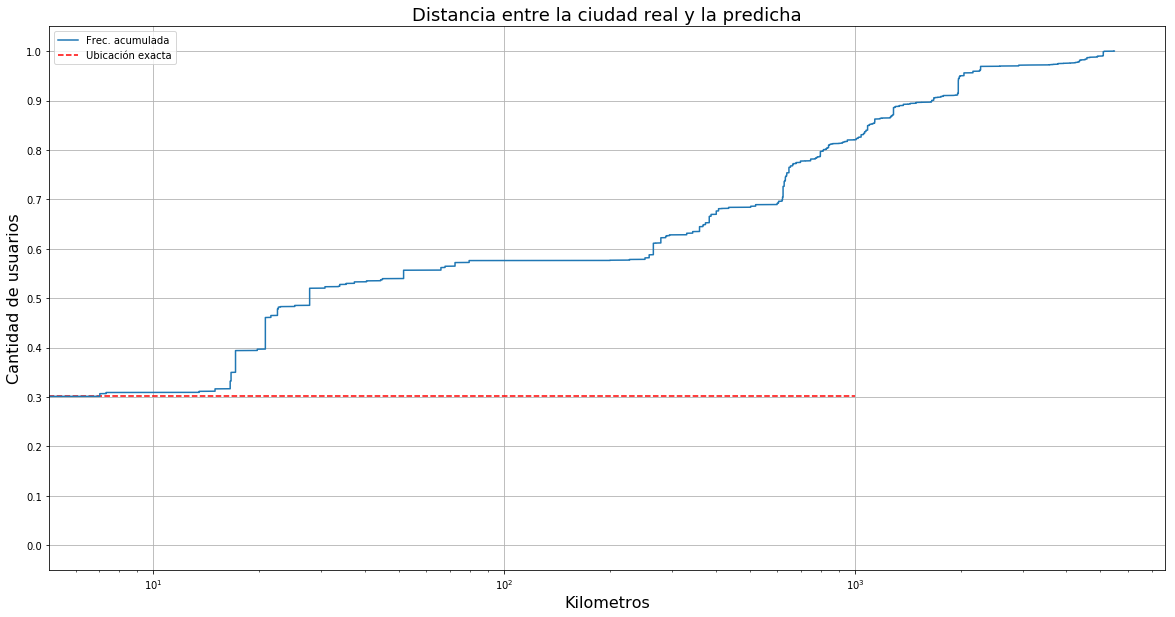

In [118]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

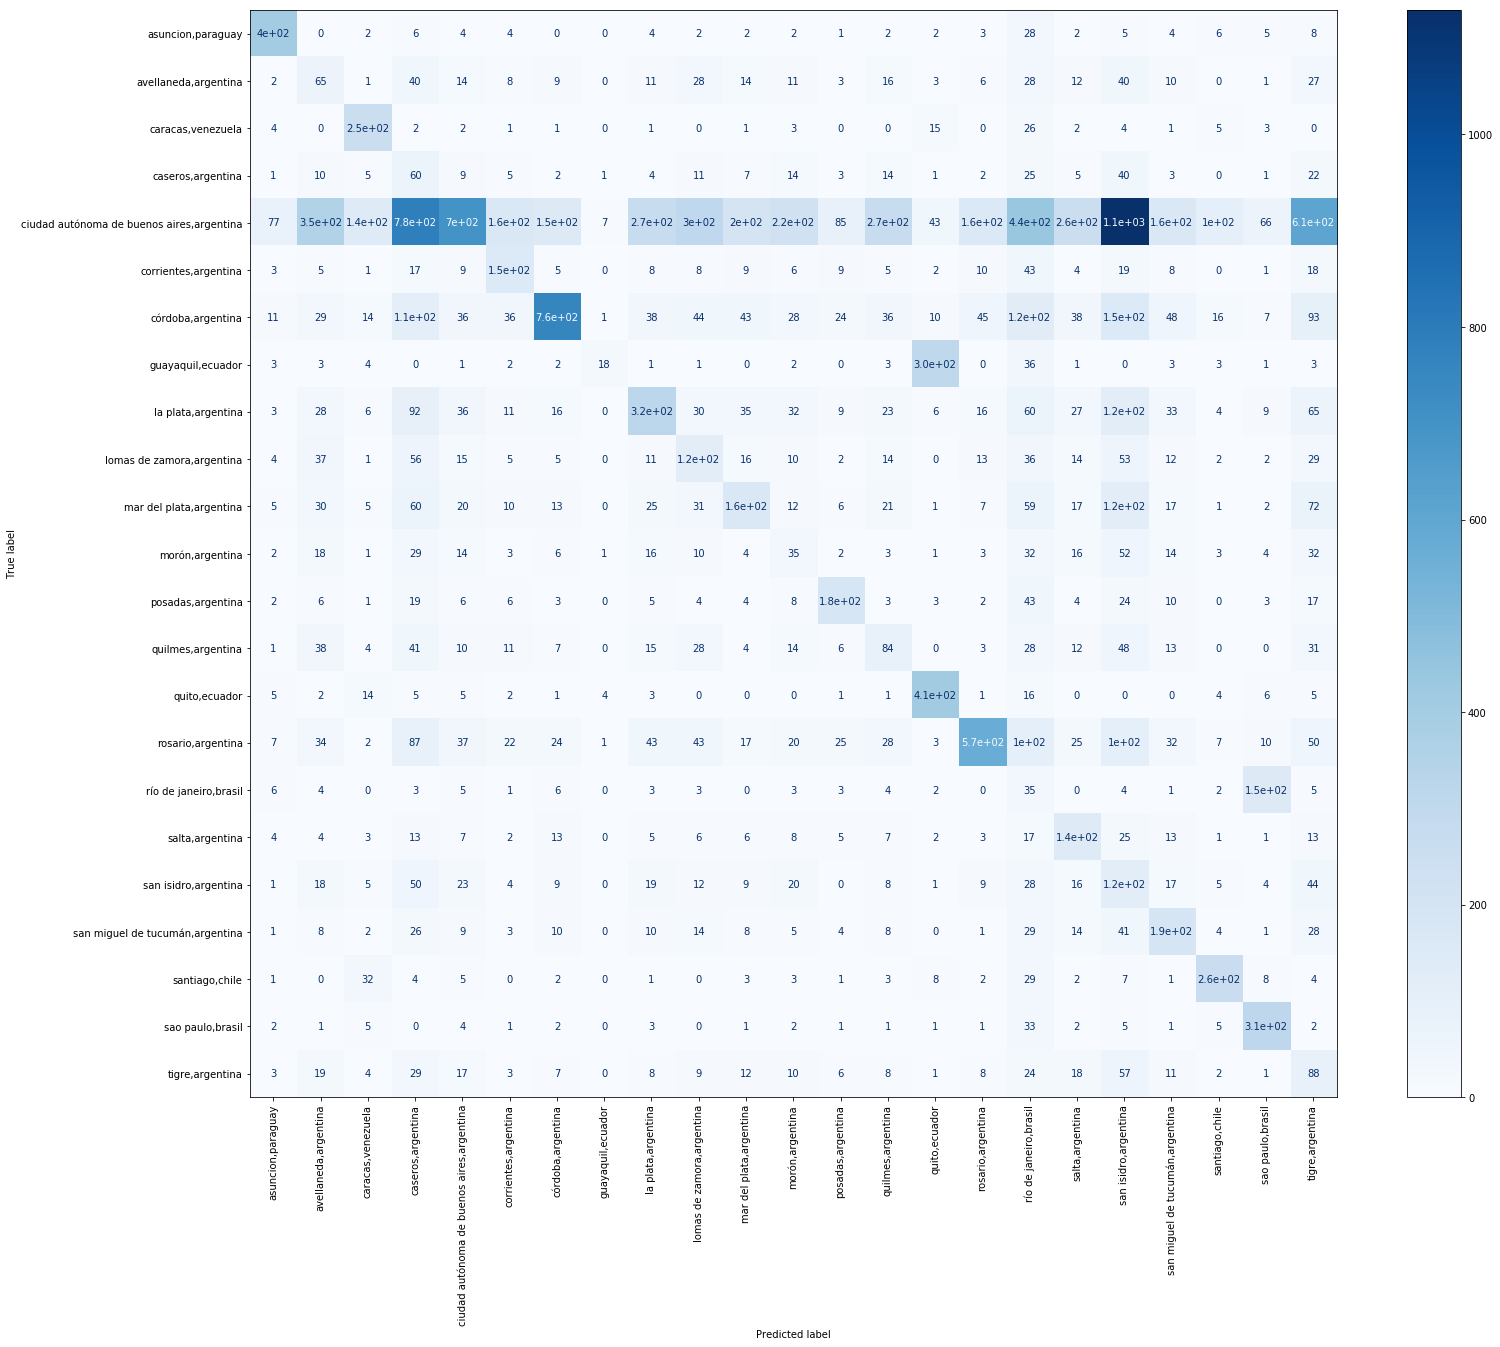

In [119]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)

In [243]:
svm = SVC()
svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
param_grid= {'C': [0.05, 0.2 , 0.5, 1.0, 10.0], "gamma": [0.001, 0.01, 0.1, 1, 'scale'],
             'class_weight': ['balanced']}
grid_drop = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

In [ ]:
y_predicted = grid_drop.predict(X_test)

In [132]:
accuracy_score(y_test, y_predicted)

0.33607697013514265

In [133]:
balanced_accuracy_score(y_test, y_predicted)

0.3889525622915881

In [134]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

Total NaN:  0


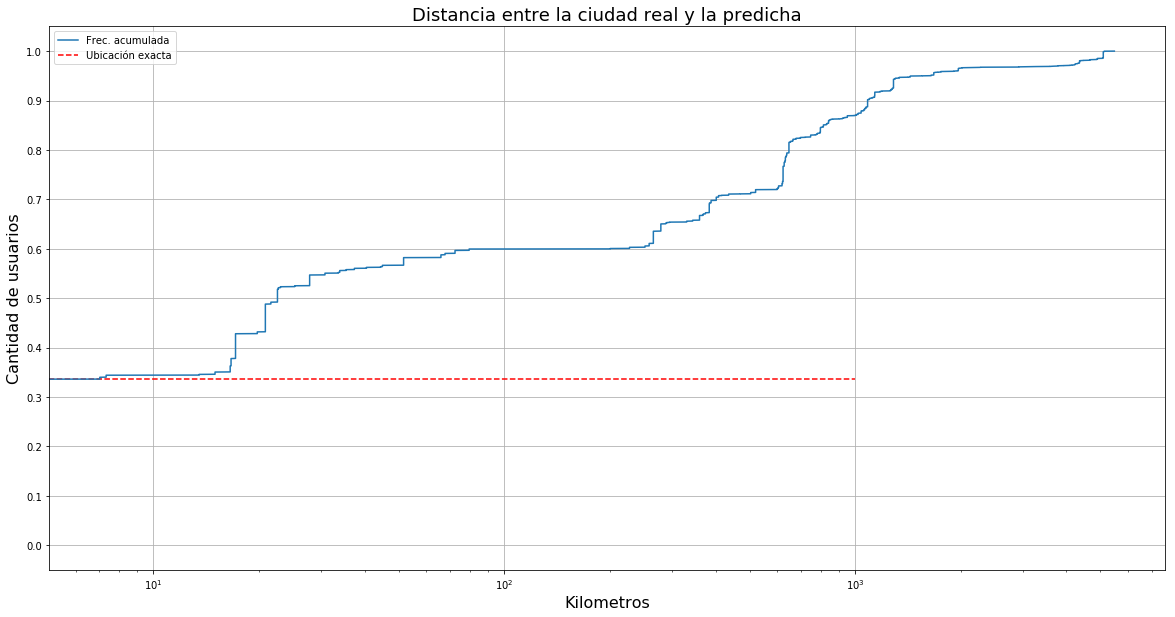

In [135]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

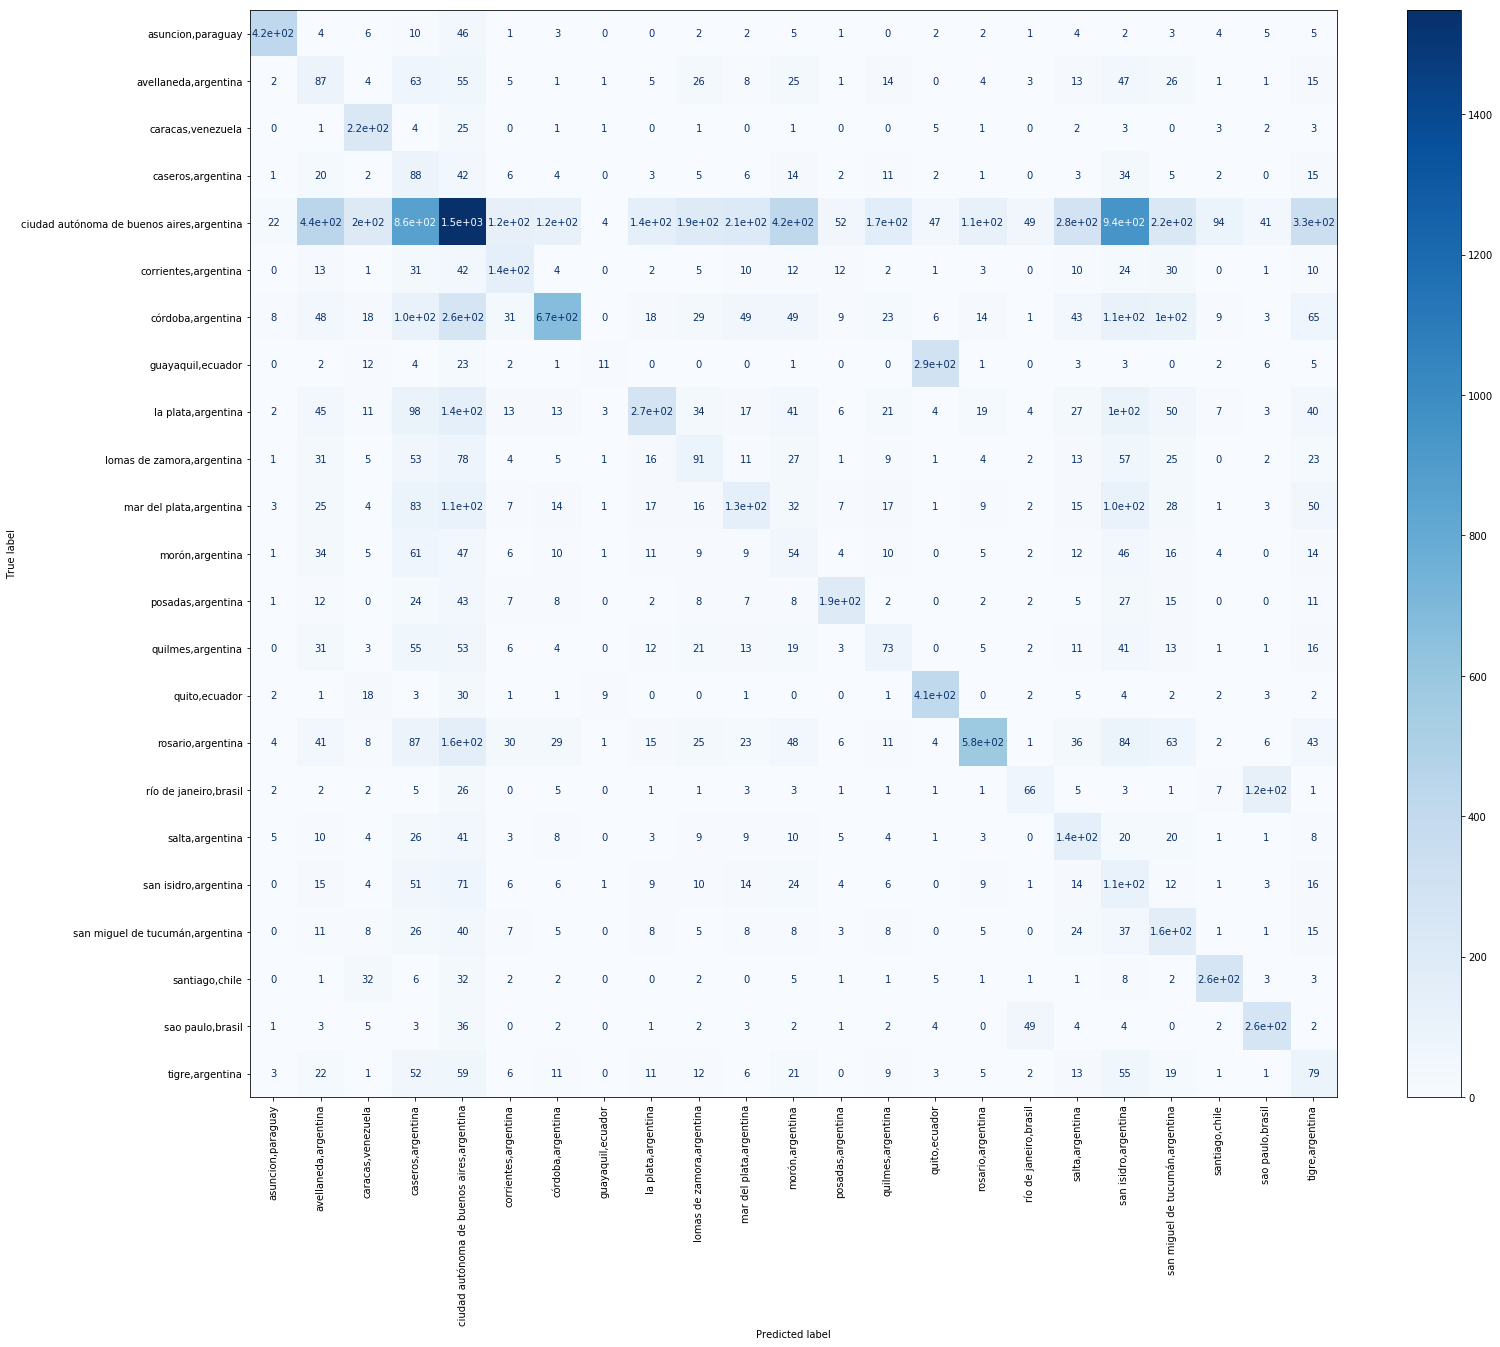

In [136]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)

In [ ]:
param_grid= {'C': [0.5, 1.0],
             'class_weight': ['balanced']}
grid_drop = GridSearchCV(svm, param_grid, cv=5, scoring='balanced_accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

In [161]:
svd = TruncatedSVD(n_components=50)

vector_of_clusters_svd = svd.fit_transform(vector_of_clusters)

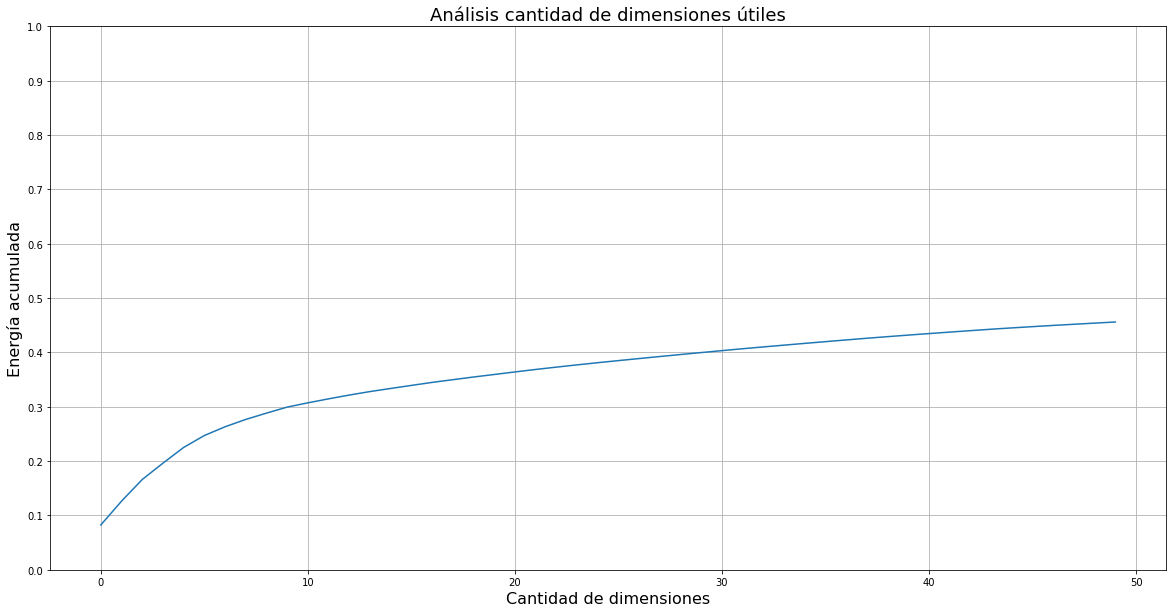

In [162]:
plt.figure(figsize=(20,10)) 

#plt.semilogy(svd.explained_variance_ratio_.cumsum(), '--o')
plt.grid(b=True, which='major')
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel("Cantidad de dimensiones", fontsize=16)
plt.ylabel("Energía acumulada", fontsize=16)
plt.title("Análisis cantidad de dimensiones útiles", fontsize=18)
plt.yticks(np.arange(0,1.1,0.1))
plt.show()

In [215]:
tsne = TSNE(n_components=2, n_jobs=5, perplexity=30, learning_rate=200.0)
vector_of_clusters_tsne = tsne.fit_transform(vector_of_clusters)

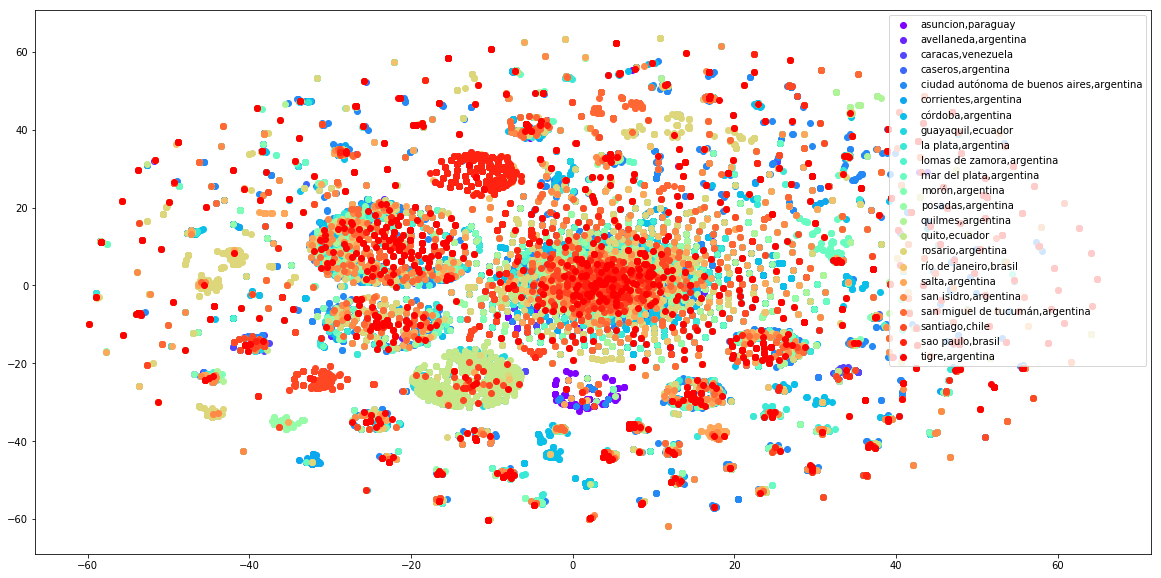

In [216]:
plt.figure(figsize=(20,10)) 
i = 0
#colors = []
colors = cm.rainbow(np.linspace(0, 1, len(class_names)))

for _class in np.array(class_names):
    a = np.where(users_complete_location[:,0] == _class)

    #for _p in range(0, len(a[0])):
    #    colors.append(i)
    
    plt.scatter(vector_of_clusters_tsne[a[0], 0], vector_of_clusters_tsne[a[0], 1], c=colors[i].reshape(1, 4), label=_class)
    i = i + 1
    #colors = []
  
plt.legend()    
plt.show()

New

In [43]:
users_complete_location = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_final['unified_place'].unique())

In [44]:
users_train_final = users_train_final.loc[:, ["clusters"]]

users_train_final.shape

(59934, 1)

In [45]:
users_train_final["clusters"] = users_train_final["clusters"].apply(lambda l: list(map(str, l)))

In [46]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=False,
)

vector_of_clusters = vectorizer.fit_transform(users_train_final["clusters"].apply(lambda x: ' '.join(x))).astype('bool').astype('int')
vector_of_clusters

<59934x5135 sparse matrix of type '<class 'numpy.int64'>'
	with 62489 stored elements in Compressed Sparse Row format>

In [47]:
estimators = [
    {
        "name": "LightGBM",
        "estimator": lgb.LGBMClassifier(n_jobs=1, objective="multiclass", random_state=1500),
        "params_grid": {'max_depth': [8, 80, 200, -1], 'class_weight': ['balanced']}
    },    
    {
        "name": "SVC",
        "estimator": SVC(kernel="rbf", probability=True, random_state=1500),
        "params_grid": {"C": [1, 10, 100], "gamma": [.01, .1], 'class_weight': ['balanced']}
    },
    {
        "name": "DecisionTree",
        "estimator": DecisionTreeClassifier(random_state=1500),
        "params_grid": {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1], 'class_weight': ['balanced']}
    },
    {
        "name": "RandomForest",
        "estimator": RandomForestClassifier(n_jobs=-1, random_state=1500),
        "params_grid": {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1], 'class_weight': ['balanced']}
    }
]

In [48]:
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=44540570)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=45405450)

In [49]:
scores = {}
predictions = {}

for estimator in estimators:
    clf = GridSearchCV(
        estimator=estimator["estimator"],
        param_grid=estimator["params_grid"],
        cv=inner_cv,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo'],
        refit='roc_auc_ovo'
    )
    
    nested_score = cross_validate(
        clf,
        X=vector_of_clusters.astype('float'),
        y=users_complete_location[:,0],
        cv=outer_cv,
        n_jobs=-1,
        scoring={
            'accuracy': 'accuracy',
            'balanced_accuracy': 'balanced_accuracy',
            'roc_auc_ovo': 'roc_auc_ovo',
            'accuracy@161': make_scorer(accuracy_161km, greater_is_better=True)            
        }
    )
    
    nested_predict = cross_val_predict(
        clf,
        X=vector_of_clusters.astype('float'),
        y=users_complete_location[:,0],
        cv=outer_cv,
        n_jobs=-1,
        method='predict'
    )
        
    scores[estimator["name"]] = nested_score
    predictions[estimator["name"]] = nested_predict

In [50]:
scores

{'LightGBM': {'fit_time': array([326.68338561, 329.25871849, 332.81496954, 327.69376087,
         326.68785548]),
  'score_time': array([18.11139727, 13.64658499, 16.90854287, 17.4341011 , 18.78452039]),
  'test_accuracy': array([0.26236756, 0.26336865, 0.27137733, 0.26420289, 0.26322376]),
  'test_balanced_accuracy': array([0.33805405, 0.33978955, 0.34179571, 0.34124496, 0.33916365]),
  'test_roc_auc_ovo': array([0.80268809, 0.80980196, 0.804041  , 0.80633884, 0.80374832]),
  'test_accuracy@161': array([0.51497456, 0.51105364, 0.51397347, 0.51530825, 0.52010679])},
 'SVC': {'fit_time': array([7402.71452165, 7946.11255956, 7609.37828565, 7632.109128  ,
         7876.68458414]),
  'score_time': array([95.06259322, 67.32881141, 90.71463776, 87.0542562 , 73.82625341]),
  'test_accuracy': array([0.54675899, 0.54859431, 0.54967882, 0.54867773, 0.54647088]),
  'test_balanced_accuracy': array([0.33808096, 0.3458745 , 0.34571719, 0.34121149, 0.34408428]),
  'test_roc_auc_ovo': array([0.7626666

In [51]:
df = pd.DataFrame(
    {
        "estimator": scores.keys(),
        "accuracy": [x["test_accuracy"] for x in scores.values()],
        "balanced_acc": [x["test_balanced_accuracy"] for x in scores.values()],
        "roc_auc": [x["test_roc_auc_ovo"] for x in scores.values()],
        "accuracy@161": [x["test_accuracy@161"] for x in scores.values()],
    }
)

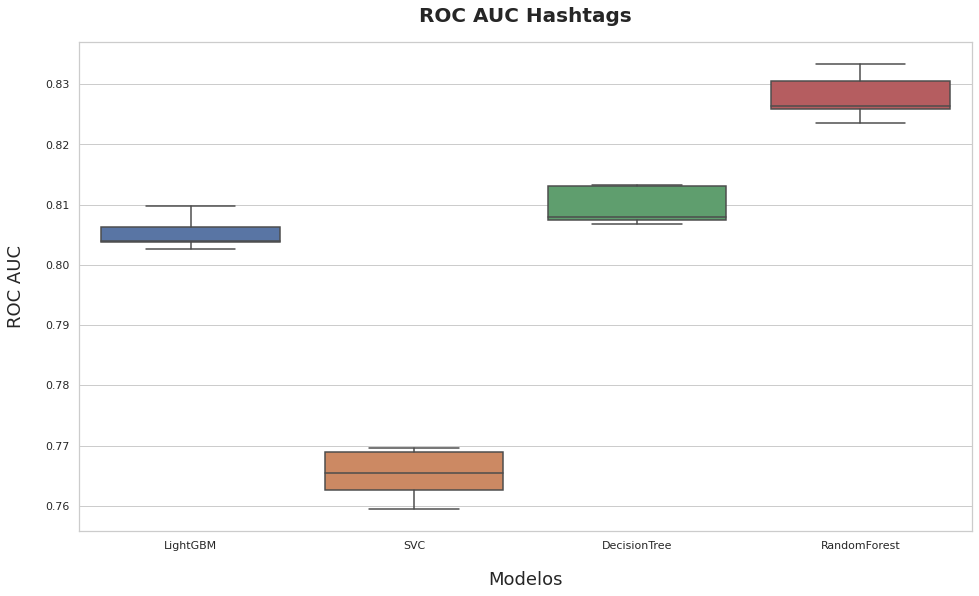

In [52]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(
    x="estimator",
    y="roc_auc",
    data=df.explode("roc_auc"),
    ax=ax
)

ax.set_title("ROC AUC Hashtags", fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel("Modelos", fontsize=18, labelpad=20)
ax.set_ylabel("ROC AUC", fontsize=18, labelpad=20)

sns.set_theme()

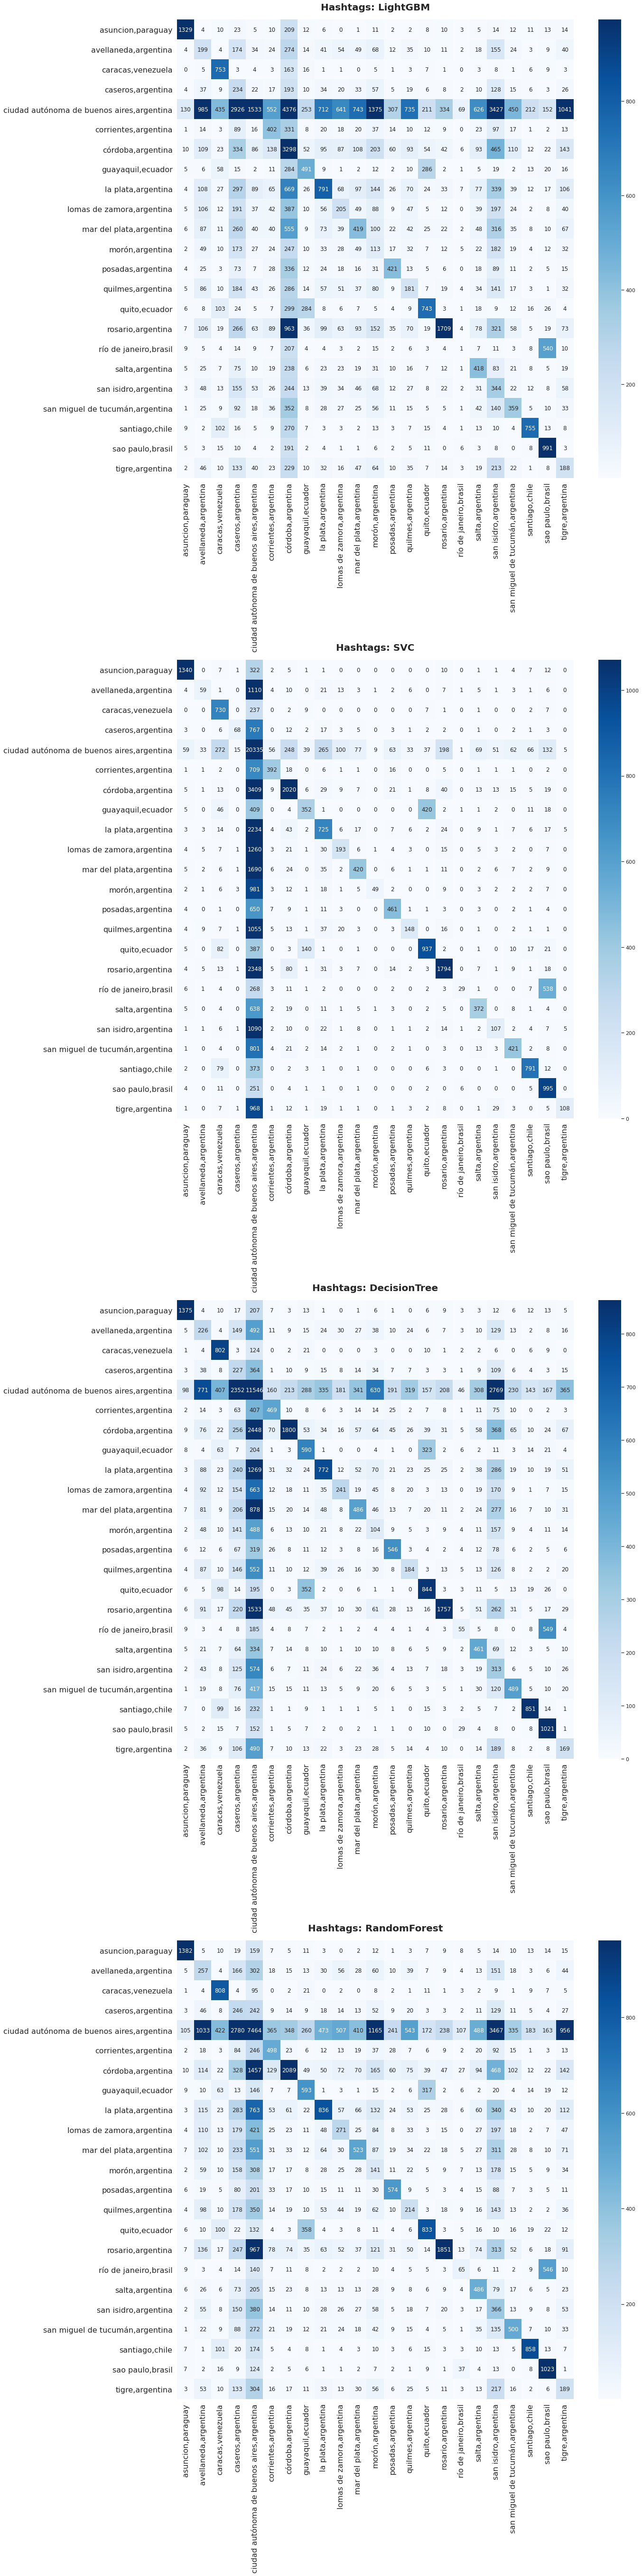

In [53]:
f, ax = plt.subplots(nrows=len(predictions), figsize=(25, 20*len(predictions)))
i = 0
f.tight_layout(pad=30.0)

for key in predictions:
    cm = confusion_matrix(users_complete_location[:,0], predictions[key], labels=class_names)

    sns.heatmap(
        cm,
        annot=True,
        #linewidths=.5,
        fmt='d',
        robust=True,
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax[i]
    )
    
    ax[i].set_title("Hashtags: " + key, fontsize=20, fontweight='bold', pad=20)
    ax[i].xaxis.set_tick_params(labelsize=16)
    ax[i].yaxis.set_tick_params(labelsize=16)

    i += 1

# Utilidad - Creacion de set de datos limitando menciones

In [3]:
def filter_users_with_mentions(min_mentions=None, max_mentions=None):
    '''
        min_mentions: Filtrar usuarios que no fueron mencionados al menos N veces.
        max_mentions: Filtrar usuarios que fueron mencionados más de M veces.
        
        Nota: Se devuelven todos los usuarios posibles, aun aquellos que luego del filtro quedan
        sin aristas hacia otros nodos, simplemente tendrán una lista de menciones vacia
        (Esto puede aprovecharse para distribuir clases de forma equitativa)
    '''
    
    # Leemos el dataframe que contiene las menciones de cada usuario
    # user_id tweet_id user_mentioned_id
    
    usecols = ["user_id", "user_mentioned"]
    
    dtype = {
        "user_id": 'Int64',
        "user_mentioned": 'Int64'
    }
    
    tweets_with_mentions = pd.read_csv(
        dosTPath + "mentions_with_tweets_geonames.csv",
        dtype=dtype,
        usecols=usecols
    )
    
    tweets_with_mentions = \
        tweets_with_mentions.loc[tweets_with_mentions["user_id"] != tweets_with_mentions["user_mentioned"], :]
        
    # Agrupamos los usuarios mencionados según cuantos usuarios distintos los mencionan
    mention_count = tweets_with_mentions.drop_duplicates().groupby('user_mentioned').count()
    
    count = mention_count.reset_index()
    
    # Filtramos usuarios mencionados según los parámetros dados
    min_mentions = 1 if min_mentions == None else min_mentions
        
    if max_mentions != None:
        lim_mentioned_users = count.loc[
            ((count["user_id"] >= min_mentions) & (count["user_id"] <= max_mentions)),
            ["user_mentioned"]
        ]
    else:
        lim_mentioned_users = count.loc[
            (count["user_id"] >= min_mentions),
            ["user_mentioned"]
        ]
        
    # Hacemos un INNER JOIN para filtrar aquellos usuarios mencionados que no cumplan
    # con los parámetros dados
    tweets_with_mentions_limit = pd.merge(
        left=tweets_with_mentions,
        right=lim_mentioned_users,
        how='inner',
        left_on=["user_mentioned"],
        right_on=["user_mentioned"],
        validate="m:1" 
    )
    
    users_mentioned = set(tweets_with_mentions_limit["user_mentioned"].values)
    
    tweets_with_mentions_limit = tweets_with_mentions_limit.groupby(
        ["user_id"]
    )['user_mentioned'].apply(list).reset_index(name='users_mentioned')
    
    # Cargamos todos los usuarios que poseemos para incorporar datos como la ubicación
    usecols = [
        "id",
        "place_name",
        "place_country",
        "latitude",
        "longitude"
    ]

    users = pd.read_pickle(unTPath + "bounding_box/total_users_parsed.pkl")

    users = users.loc[:, usecols]
    
    users_with_mentions = pd.merge(
        left=users,
        right=tweets_with_mentions_limit,
        how='left',
        left_on=["id"],
        right_on=["user_id"],
        validate="1:1" 
    )
    
    del users_with_mentions["user_id"]
    
    print(
        "Total users:", users.shape[0],
        "\nUsers with mentions:", tweets_with_mentions_limit.shape[0],
        "\nUsers in @mention graph:", len(
            set(users["id"].values).intersection(users_mentioned) | 
            set(tweets_with_mentions_limit["user_id"].unique())
        ),
        "\nUsers mentioned:", len(users_mentioned)
    )
    
    return users_with_mentions

In [5]:
users_with_mentions = filter_users_with_mentions(None, None)
users_with_mentions.to_pickle(unTPath + "bounding_box/users_with_mentions.pkl")

Total users: 141209 
Users with mentions: 129040 
Users in @mention graph: 136795 
Users mentioned: 1189981


In [15]:
users_with_mentions.head()

id           place_name place_country   latitude  \
0  773970163502870528  guadalajara de buga      colombia   3.900890   
1            77573705                quito       ecuador  -0.229850   
2  782687718576840704               tolosa        españa  43.134838   
3  781920345536225280            san pedro     argentina -33.679180   
4            78502559            guayaquil       ecuador  -2.196160   

   longitude                                    users_mentioned  
0 -76.297829                                                NaN  
1 -78.524948                   [300390462, 14369839, 343818604]  
2  -2.078010  [10228272, 862042934023159809, 17192256, 17192...  
3 -59.666328                                                NaN  
4 -79.886208                                                NaN

In [6]:
users_with_mentions = filter_users_with_mentions(None, 20)
users_with_mentions.to_pickle(unTPath + "bounding_box/users_with_mentions.pkl")

Total users: 141209 
Users with mentions: 111721 
Users in @mention graph: 122342 
Users mentioned: 1162707
